## Problem Statement

A cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth from the neutral mutations. 
Considering this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations based on evidence from text-based clinical literature.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import time
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize,StandardScaler, OneHotEncoder
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore")

#### Loading the data:

In [2]:
data=pd.read_csv('training_variants')
print('Total gene variations:',data.shape[0])
print('Total features:',data.shape[1])
print('Features:',data.columns.values)
data.head()

Total gene variations: 3321
Total features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
text_data=pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Total gene variations:',text_data.shape[0])
print('Total features:',text_data.shape[1])
print('Features:',text_data.columns.values)
text_data.head()

Total gene variations: 3321
Total features: 2
Features: ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### Preprocessing of Text

In [4]:
#stop words
stop_words=set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text_data[column][index] = string

In [5]:
start_time = time.perf_counter()
for index, row in text_data.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 82.68926370000008 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, text_data,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result['ID']==1277]

,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT']=result['Gene'] +' '+ result['Variation']

In [9]:
result[result['ID']==1277]

,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


In [167]:
path='unchanged_data.csv'
result.to_csv(path,index=False)
print(f"\nCleaned data successfully exported to {path}")


Cleaned data successfully exported to unchanged_data.csv


In [169]:
result['Gene_Variation'] = result['Gene'] + '_' + result['Variation']

In [174]:
result

,ID,Class,TEXT,Gene_Variation
0,0,1,cyclin dependent kinases cdks regulate variety...,FAM58A_Truncating Mutations
1,1,2,abstract background non small cell lung cancer...,CBL_W802*
2,2,2,abstract background non small cell lung cancer...,CBL_Q249E
3,3,3,recent evidence demonstrated acquired uniparen...,CBL_N454D
4,4,4,oncogenic mutations monomeric casitas b lineag...,CBL_L399V
...,...,...,...,...
3316,3316,4,introduction myelodysplastic syndromes mds het...,RUNX1_D171N
3317,3317,1,introduction myelodysplastic syndromes mds het...,RUNX1_A122*
3318,3318,1,runt related transcription factor 1 gene runx1...,RUNX1_Fusions
3319,3319,4,runx1 aml1 gene frequent target chromosomal tr...,RUNX1_R80C


In [175]:
path='changed_data.csv'
result.to_csv(path,index=False)
print(f"\nCleaned data successfully exported to {path}")


Cleaned data successfully exported to changed_data.csv


### Train, CV and Test Datasets

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### Distribution of yi's in all splits:

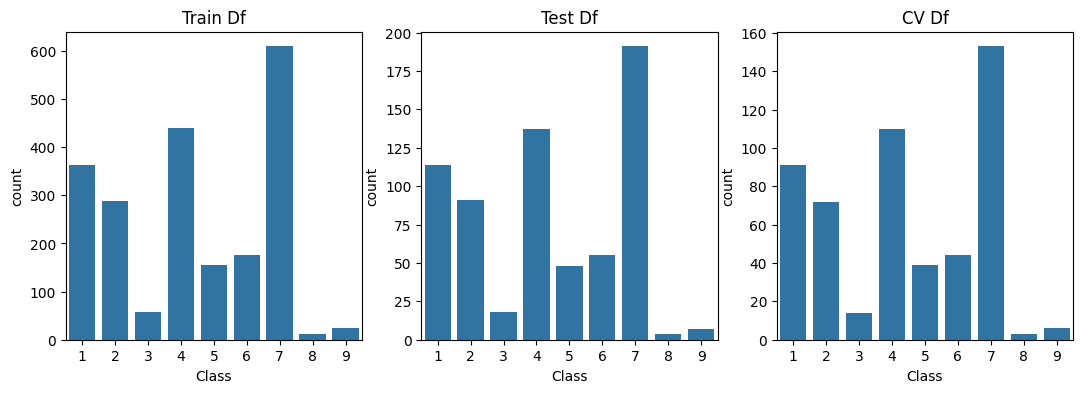

In [12]:
fig, axes = plt.subplots(1,3,figsize=(13, 4))

sns.barplot(train_df['Class'].value_counts(),ax=axes[0])
sns.barplot(test_df['Class'].value_counts(),ax=axes[1])
sns.barplot(cv_df['Class'].value_counts(),ax=axes[2])
axes[0].set_title('Train Df')
axes[1].set_title('Test Df')
axes[2].set_title('CV Df')
plt.show()

Distribution of Train, Test and CV data are roughly same and each of imbalanced data.

### Random Model

In [13]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T) #recall
    B =(C/C.sum(axis=0)) #precision
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [14]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
np.random.seed(42)
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
test_predicted_y=np.zeros((test_data_len,9))
np.random.seed(42)
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y))
print("Log loss on Test Validation Data using Random Model",log_loss(y_test,test_predicted_y))

Log loss on Cross Validation Data using Random Model 2.4724312915910263
Log loss on Test Validation Data using Random Model 2.51757069437209


-------------------- Confusion matrix --------------------


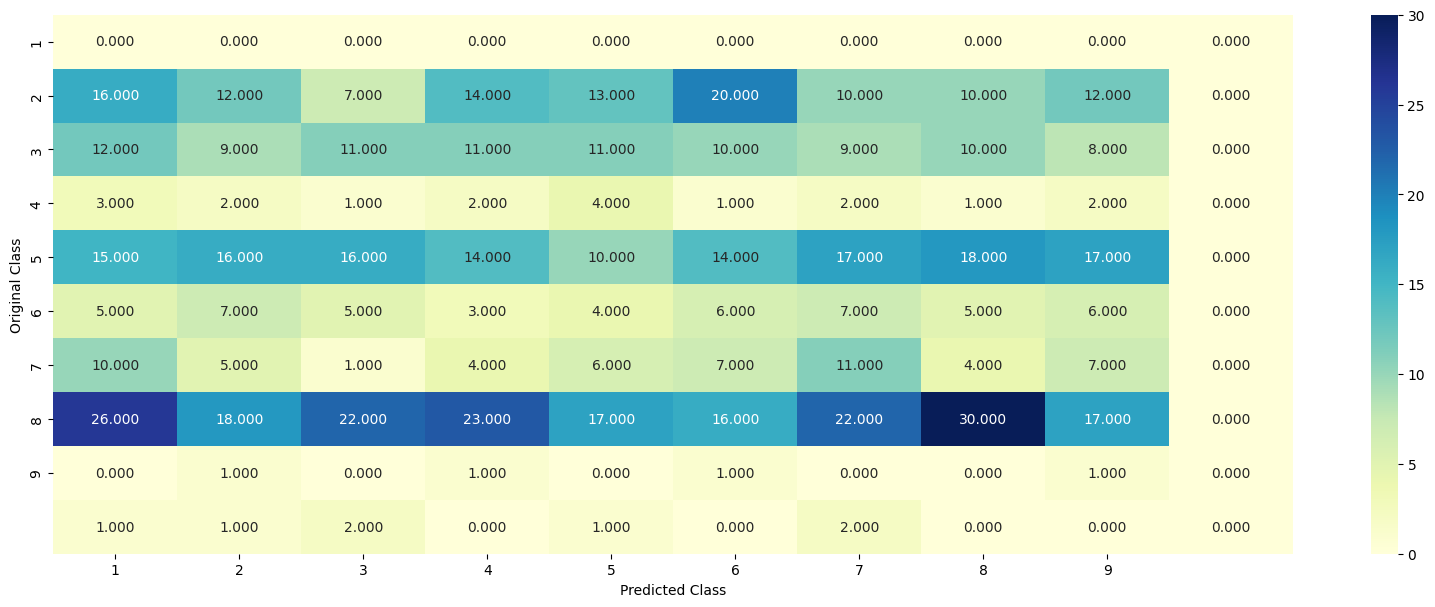

-------------------- Precision matrix (Columm Sum=1) --------------------


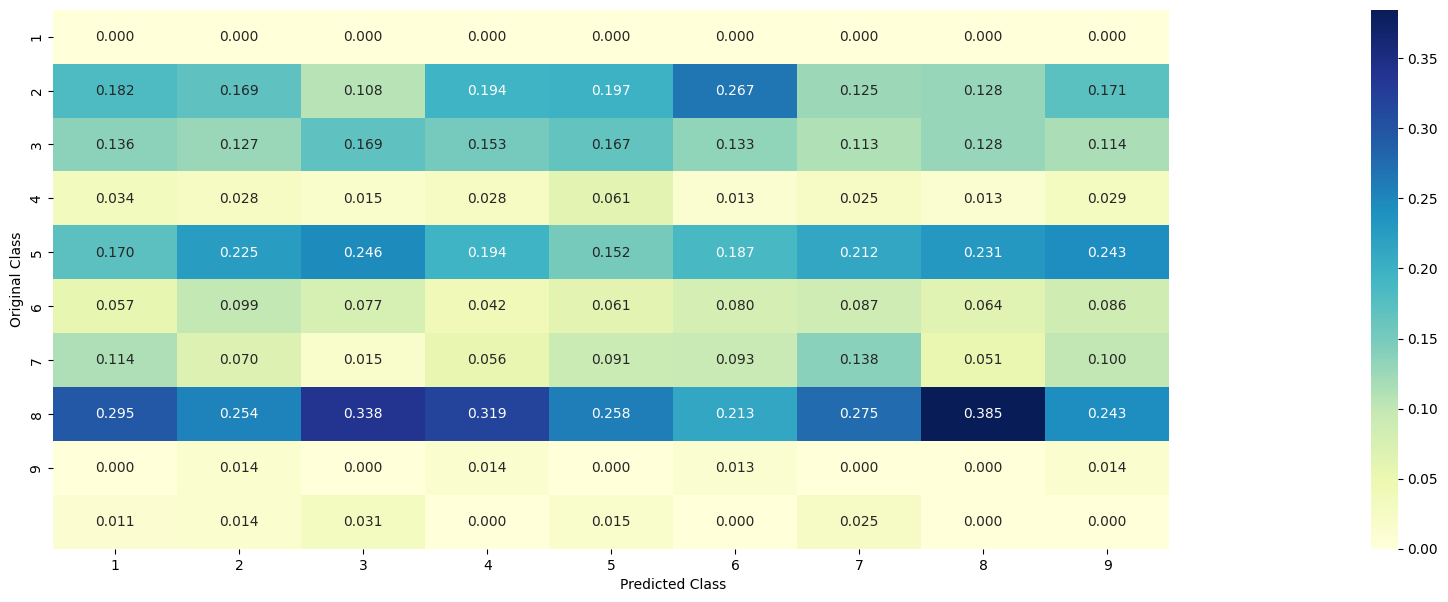

-------------------- Recall matrix (Row sum=1) --------------------


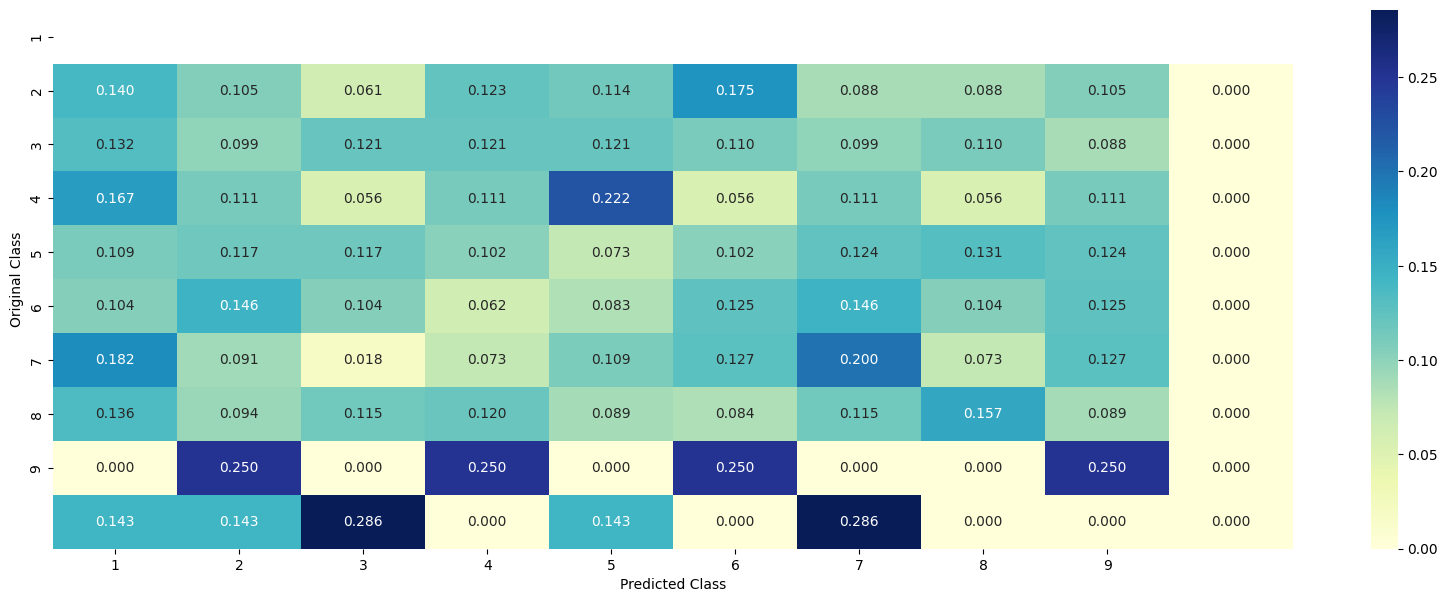

In [15]:
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test,predicted_y)

### Univariate Analysis of Gene Feature

In [16]:
print('Unique Gene counts:',train_df['Gene'].value_counts().shape[0])
train_df['Gene'].value_counts().head(10)

Unique Gene counts: 239


Gene
BRCA1     164
TP53      106
EGFR       97
BRCA2      84
PTEN       82
KIT        65
BRAF       57
ALK        44
ERBB2      42
PDGFRA     37
Name: count, dtype: int64

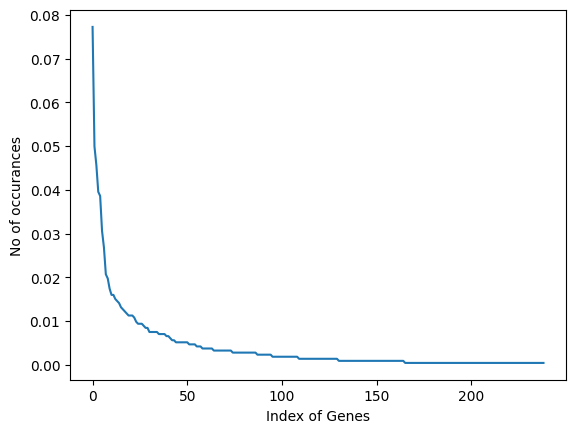

In [17]:
h=sum(train_df['Gene'].value_counts().values)
s=(train_df['Gene'].value_counts().values)/h

plt.plot(s)
plt.xlabel('Index of Genes')
plt.ylabel('No of occurances')
plt.show()

In [18]:
train_df['Gene'].value_counts().values

array([164, 106,  97,  84,  82,  65,  57,  44,  42,  37,  34,  34,  32,
        31,  30,  28,  27,  26,  25,  24,  24,  24,  23,  21,  20,  20,
        20,  19,  18,  18,  16,  16,  16,  16,  16,  15,  15,  15,  15,
        14,  14,  13,  12,  12,  11,  11,  11,  11,  11,  11,  11,  10,
        10,  10,  10,   9,   9,   9,   8,   8,   8,   8,   8,   8,   7,
         7,   7,   7,   7,   7,   7,   7,   7,   7,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   5,   5,   5,   5,
         5,   5,   5,   5,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [19]:
#Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [20]:
###---response coding
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
train_gene_feature_responseCoding = (train_gene_feature_responseCoding.T / train_gene_feature_responseCoding.sum(axis=1)).T

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
test_gene_feature_responseCoding = (test_gene_feature_responseCoding.T / test_gene_feature_responseCoding.sum(axis=1)).T

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))
cv_gene_feature_responseCoding = (cv_gene_feature_responseCoding.T / cv_gene_feature_responseCoding.sum(axis=1)).T

In [21]:
# TfidfVectorizer of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])
train_gene_feature_onehotCoding = normalize(train_gene_feature_onehotCoding, axis=0)
test_gene_feature_onehotCoding = normalize(test_gene_feature_onehotCoding, axis=0)
cv_gene_feature_onehotCoding = normalize(cv_gene_feature_onehotCoding, axis=0)

In [22]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid1b', 'arid2', 'asxl1', 'asxl2', 'atm',
       'atr', 'atrx', 'aurkb', 'axl', 'b2m', 'bap1', 'bard1', 'bcl10',
       'bcl2', 'bcl2l11', 'bcor', 'braf', 'brca1', 'brca2', 'brd4',
       'brip1', 'btk', 'card11', 'carm1', 'casp8', 'cbl', 'ccnd1',
       'ccnd2', 'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8',
       'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c', 'chek2', 'cic',
       'crebbp', 'ctcf', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b',
       'dusp4', 'egfr', 'eif1ax', 'elf3', 'ep300', 'epas1', 'epcam',
       'erbb2', 'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg',
       'errfi1', 'esr1', 'etv1', 'etv6', 'ewsr1', 'ezh2', 'fam58a',
       'fanca', 'fancc', 'fat1', 'fbxw7', 'fgf3', 'fgf4', 'fgfr1',
       'fgfr2', 'fgfr3', 'fgfr4', 'flt3', 'foxa1', 'foxl2', 'foxp1',
       'fubp1', 'gata3', 'gli1', 'gna11', 'gnaq', 'gnas', 'h3f3a',
       'hist1h1c', '

In [23]:
##to check how good is the feature gene for predicting yi with one hot encoding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


For values of alpha =  1e-05 The log loss is: 1.162344674790251
For values of alpha =  0.0001 The log loss is: 1.1605752192784327
For values of alpha =  0.001 The log loss is: 1.1640860663469064
For values of alpha =  0.01 The log loss is: 1.2003532818874991
For values of alpha =  0.1 The log loss is: 1.283336581117485
For values of alpha =  1 The log loss is: 1.2962992307918202
For values of best alpha =  0.0001 The train log loss is: 1.0282904167706668
For values of best alpha =  0.0001 The cross validation log loss is: 1.1605752192784327
For values of best alpha =  0.0001 The test log loss is: 1.2064827596226484


In [24]:
##to check how good is the feature gene for predicting yi with response coding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 1.2548684734292128
For values of alpha =  0.0001 The log loss is: 1.2669563459663238
For values of alpha =  0.001 The log loss is: 1.3211643038499228
For values of alpha =  0.01 The log loss is: 1.3579085381992437
For values of alpha =  0.1 The log loss is: 1.363988982973328
For values of alpha =  1 The log loss is: 1.3651000838096643
For values of best alpha =  1e-05 The train log loss is: 1.1772749290172233
For values of best alpha =  1e-05 The cross validation log loss is: 1.2548684734292128
For values of best alpha =  1e-05 The test log loss is: 1.2652970347601615


#### with clear comparasion of log loss among cross and test data are close to eachother which implies Gene feature is stable.

### Univariate Analysis of Variation Feature

In [25]:
print('Unique Variation counts:',train_df['Variation'].value_counts().shape[0])
train_df['Variation'].value_counts().head(10)

Unique Variation counts: 1926


Variation
Deletion                59
Truncating Mutations    57
Amplification           35
Fusions                 26
T58I                     3
Q61L                     3
Overexpression           3
G67R                     2
G12S                     2
Q209L                    2
Name: count, dtype: int64

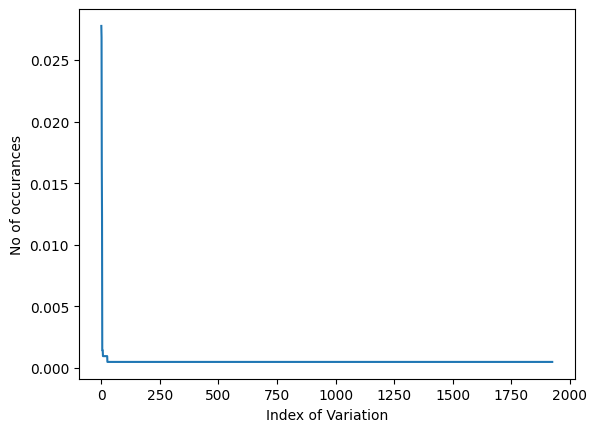

In [26]:
h=sum(train_df['Variation'].value_counts().values)
s=(train_df['Variation'].value_counts().values)/h

plt.plot(s)
plt.xlabel('Index of Variation')
plt.ylabel('No of occurances')
plt.show()

In [27]:
###---response coding
alpha=1
# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
train_variation_feature_responseCoding=(train_variation_feature_responseCoding.T/train_variation_feature_responseCoding.sum(axis=1)).T
# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
test_variation_feature_responseCoding = (test_variation_feature_responseCoding.T/test_variation_feature_responseCoding.sum(axis=1)).T
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))
cv_variation_feature_responseCoding=(cv_variation_feature_responseCoding.T/cv_variation_feature_responseCoding.sum(axis=1)).T

In [28]:
# TfidfVectorizer of Variation feature.
variation_vectorizer = TfidfVectorizer()
#train variation feature
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
#test variation feature
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
#cv variation feature
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])
train_variation_feature_onehotCoding = normalize(train_variation_feature_onehotCoding,axis=0)
test_variation_feature_onehotCoding = normalize(test_variation_feature_onehotCoding,axis=0)
cv_variation_feature_onehotCoding = normalize(cv_variation_feature_onehotCoding,axis=0)

In [29]:
variation_vectorizer.get_feature_names_out()

array(['11', '126', '13', ..., 'y98h', 'yap1', 'zc3h7b'], dtype=object)

In [30]:
##to check how good is the feature variation for predicting yi with one hot encoding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 1.7042476793076915
For values of alpha =  0.0001 The log loss is: 1.6904062500768005
For values of alpha =  0.001 The log loss is: 1.6885659218546818
For values of alpha =  0.01 The log loss is: 1.6987563697286836
For values of alpha =  0.1 The log loss is: 1.7162997391145263
For values of alpha =  1 The log loss is: 1.7093072589348224
For values of best alpha =  0.001 The train log loss is: 0.4247540352336418
For values of best alpha =  0.001 The cross validation log loss is: 1.6885659218546818
For values of best alpha =  0.001 The test log loss is: 1.7414127117472744


In [31]:
##to check how good is the feature gene for predicting yi with response coding

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is: 1.8986872594388982
For values of alpha =  0.0001 The log loss is: 1.8307944459564254
For values of alpha =  0.001 The log loss is: 1.772762167573787
For values of alpha =  0.01 The log loss is: 1.7736244534198067
For values of alpha =  0.1 The log loss is: 1.7746451581591876
For values of alpha =  1 The log loss is: 1.7819441952055386
For values of best alpha =  0.001 The train log loss is: 0.6465796245779614
For values of best alpha =  0.001 The cross validation log loss is: 1.772762167573787
For values of best alpha =  0.001 The test log loss is: 1.9383322211227958


#### with clear comparasion of log loss among cross and test data are almost close to eachother which implies Variation feature is stable.

### Univariate Analysis of TEXT Feature

In [32]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [33]:
# building a TfidVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53861


In [34]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [35]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [36]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [37]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [38]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [39]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({np.float64(0.006559577562367763): 321, np.float64(0.016489538686326074): 314, np.float64(0.0305818307803852): 229, np.float64(0.011313499845502785): 220, np.float64(0.05465995664879694): 194, np.float64(0.021584589452642796): 154, np.float64(0.325972733338191): 151, np.float64(0.02659858004731313): 137, np.float64(0.22406021122787645): 127, np.float64(0.0550206902860002): 125, np.float64(0.007648037983876885): 115, np.float64(0.019584710449917327): 114, np.float64(0.047227251314387556): 110, np.float64(0.057737180865217716): 103, np.float64(0.05446570310238317): 103, np.float64(0.08650933694976329): 101, np.float64(0.04341709279402517): 98, np.float64(0.02219301789582794): 95, np.float64(0.02607160431878063): 90, np.float64(0.013233337890176437): 90, np.float64(0.09784717149535965): 88, np.float64(0.026257185937217688): 88, np.float64(0.019725162150224747): 83, np.float64(0.024103300842832416): 80, np.float64(0.05397449140924911): 71, np.float64(0.020076962367845435): 69, np.f

In [40]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y))

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


For values of alpha =  1e-05 The log loss is: 1.204192461811225
For values of alpha =  0.0001 The log loss is: 1.018048219912758
For values of alpha =  0.001 The log loss is: 1.0068368225311373
For values of alpha =  0.01 The log loss is: 1.0766101995214603
For values of alpha =  0.1 The log loss is: 1.2968033948597641
For values of alpha =  1 The log loss is: 1.5949622968095067
For values of best alpha =  0.001 The train log loss is: 0.5944807180223437
For values of best alpha =  0.001 The cross validation log loss is: 1.0068368225311373
For values of best alpha =  0.001 The test log loss is: 1.0812282674839033


#### with clear comparasion of log loss among cross and test data are close to eachother which implies Text feature is stable.

## Machine Learning Models

In [41]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [42]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [43]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking three types of features

In [44]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [45]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56057)
(number of data points * number of features) in test data =  (665, 56057)
(number of data points * number of features) in cross validation data = (532, 56057)


In [46]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [47]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


### Base Line Model

#### 1. Naive Bayes

In [48]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
    
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


for alpha = 1e-05
Log Loss : 1.2135467952962253
for alpha = 0.0001
Log Loss : 1.2116656781809148
for alpha = 0.001
Log Loss : 1.2141035469021035
for alpha = 0.1
Log Loss : 1.1979553900986988
for alpha = 1
Log Loss : 1.2181142865010077
for alpha = 10
Log Loss : 1.3439818120510998
for alpha = 100
Log Loss : 1.2448858472026105
for alpha = 1000
Log Loss : 1.1761784524650276
For values of best alpha =  1000 The train log loss is: 0.9860111887296116
For values of best alpha =  1000 The cross validation log loss is: 1.1761784524650276
For values of best alpha =  1000 The test log loss is: 1.2401571969749008


Log Loss : 1.1761784524650276
Number of missclassified point : 0.424812030075188
-------------------- Confusion matrix --------------------


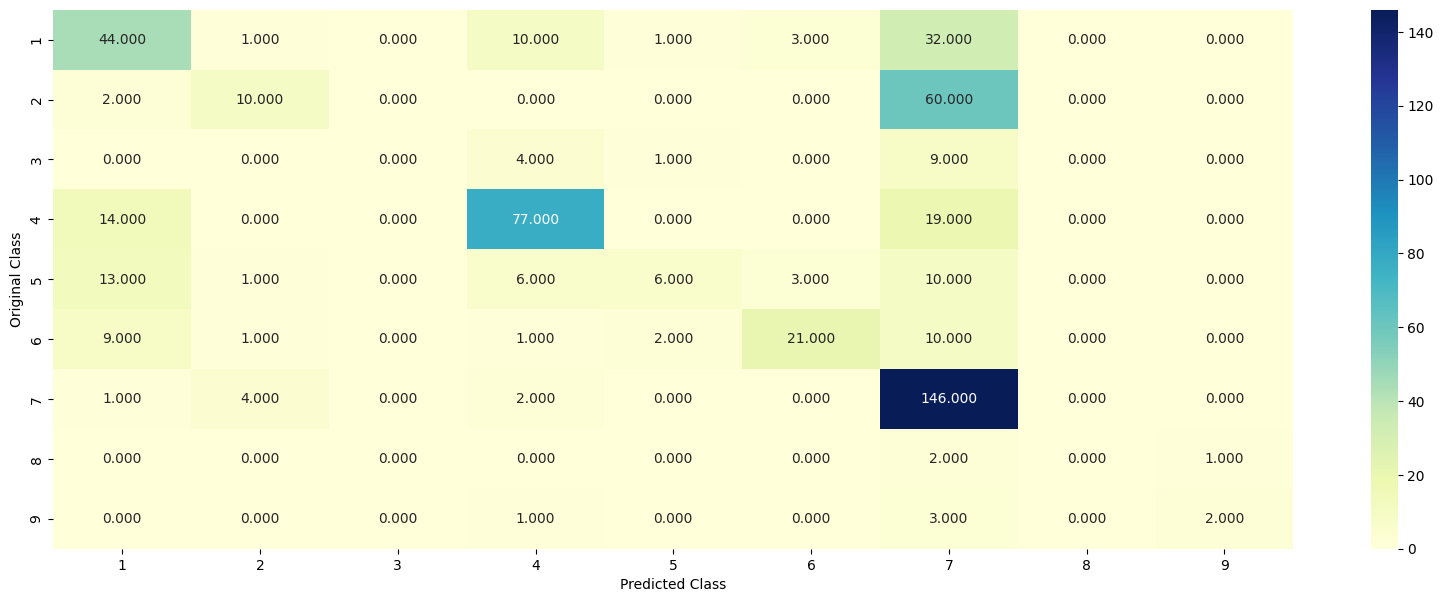

-------------------- Precision matrix (Columm Sum=1) --------------------


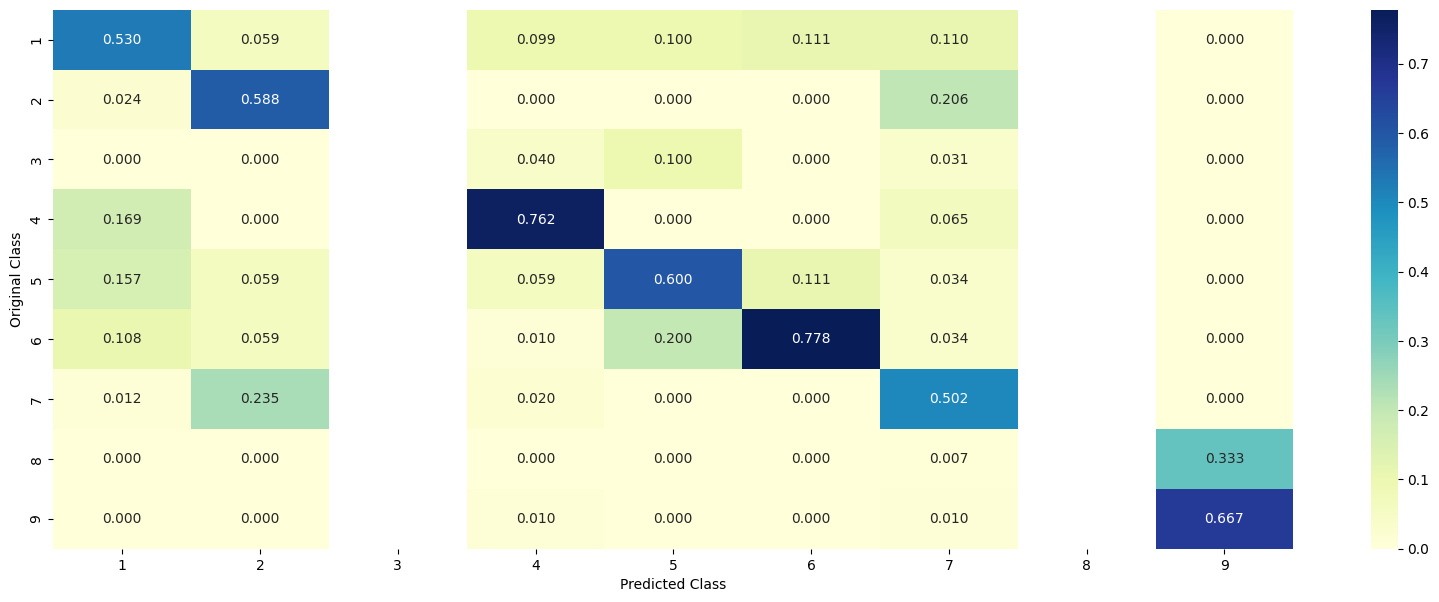

-------------------- Recall matrix (Row sum=1) --------------------


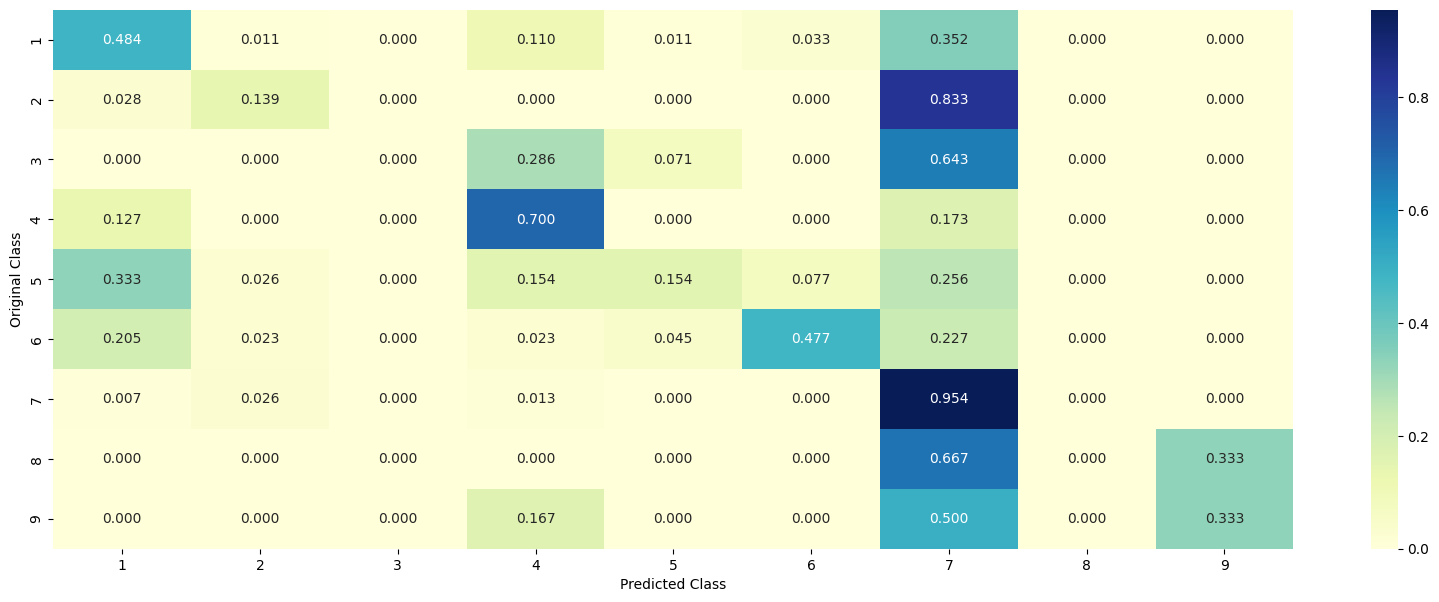

In [49]:
#Testing the model with best hyper paramters
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### 2. K-Nearest Neighbour Classification

In [57]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))


for alpha = 5
Log Loss : 1.2728465507648417
for alpha = 11
Log Loss : 1.3335268715748603
for alpha = 15
Log Loss : 1.387227205749851
for alpha = 21
Log Loss : 1.4167255222421382
for alpha = 31
Log Loss : 1.4166308897145565
for alpha = 41
Log Loss : 1.4230096212421308
for alpha = 51
Log Loss : 1.4400568945957972
for alpha = 99
Log Loss : 1.3347652569599553
For values of best alpha =  5 The train log loss is: 0.9994716397277807
For values of best alpha =  5 The cross validation log loss is: 1.2728465507648417
For values of best alpha =  5 The test log loss is: 1.2842448920657037


Log loss : 1.2728465507648417
Number of mis-classified points : 0.47368421052631576
-------------------- Confusion matrix --------------------


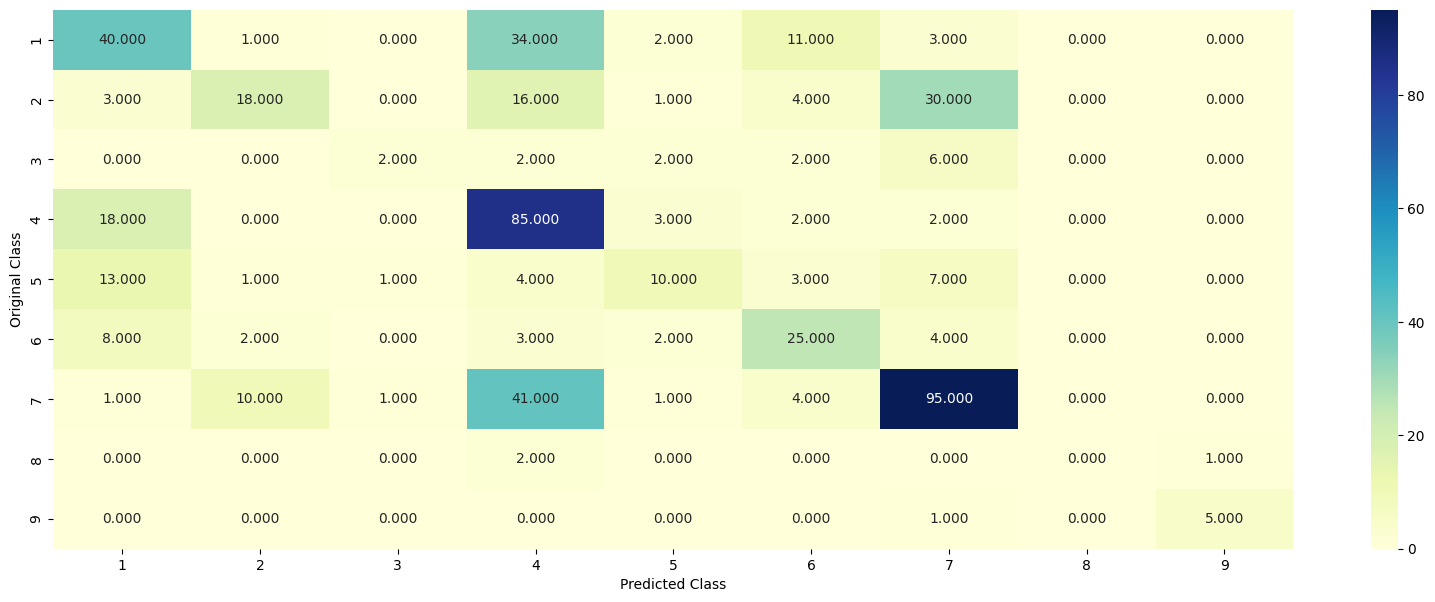

-------------------- Precision matrix (Columm Sum=1) --------------------


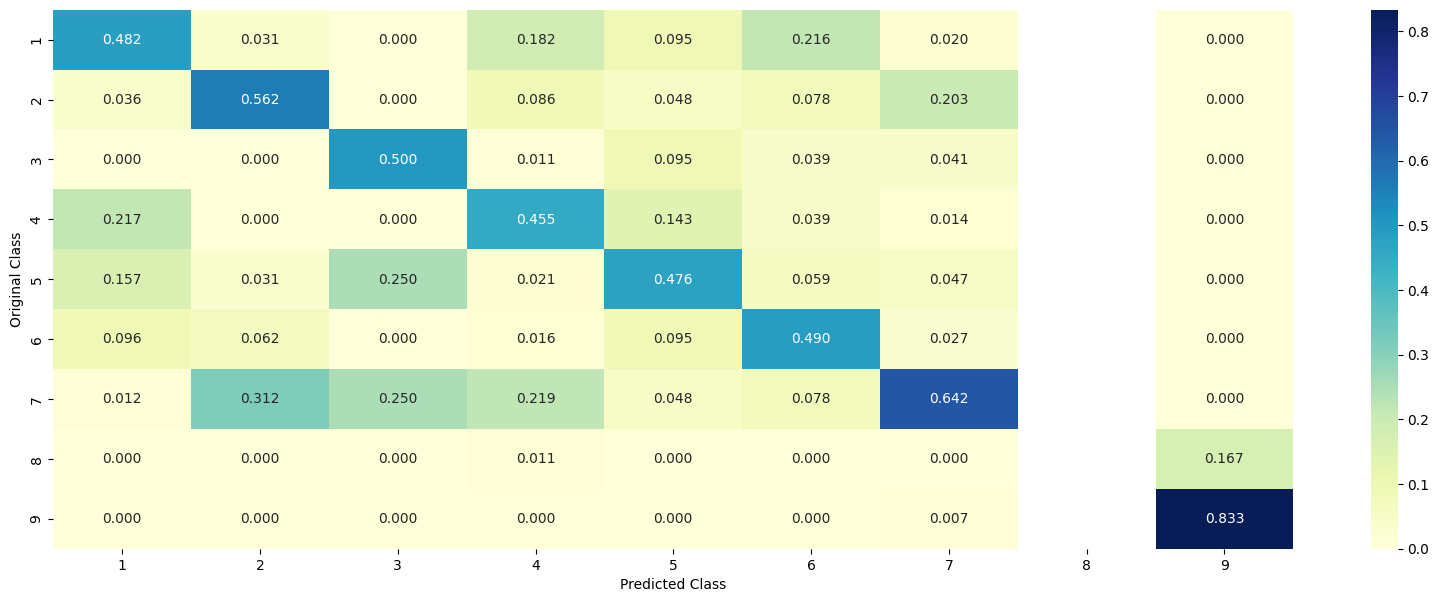

-------------------- Recall matrix (Row sum=1) --------------------


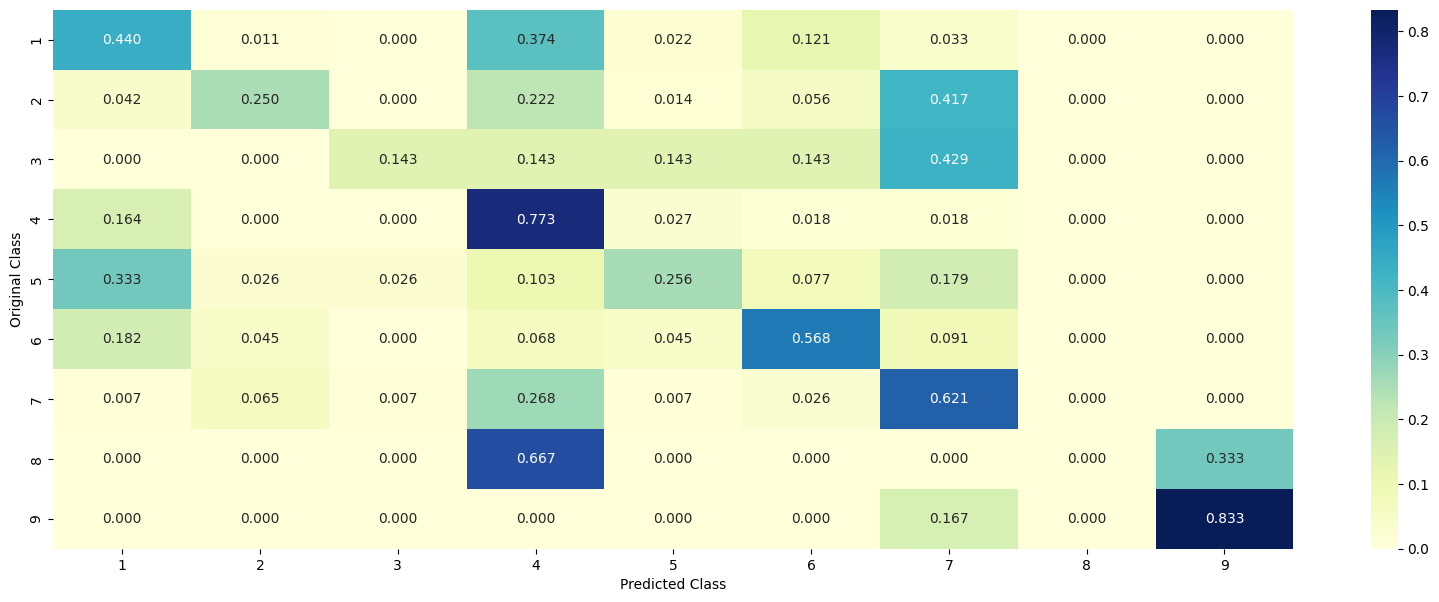

In [58]:
#Testing the model with best hyper paramters
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 3. Logistic Regression

##### 3.1. Class balancing (though we have imbalanced classes)

In [60]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42) #balanced
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for alpha = 1e-06
Log Loss : 1.2310988155623976
for alpha = 1e-05
Log Loss : 1.199078157463618
for alpha = 0.0001
Log Loss : 0.9871072978295503
for alpha = 0.001
Log Loss : 0.993149839423306
for alpha = 0.01
Log Loss : 1.057581384499948
for alpha = 0.1
Log Loss : 1.2415031765001112
for alpha = 1
Log Loss : 1.5656616265967342
for alpha = 10
Log Loss : 1.616106971901079
for alpha = 100
Log Loss : 1.6216391170816298
For values of best alpha =  0.0001 The train log loss is: 0.5292009199198747
For values of best alpha =  0.0001 The cross validation log loss is: 0.9871072978295503
For values of best alpha =  0.0001 The test log loss is: 1.0789516530415415


Log loss : 0.9871072978295503
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


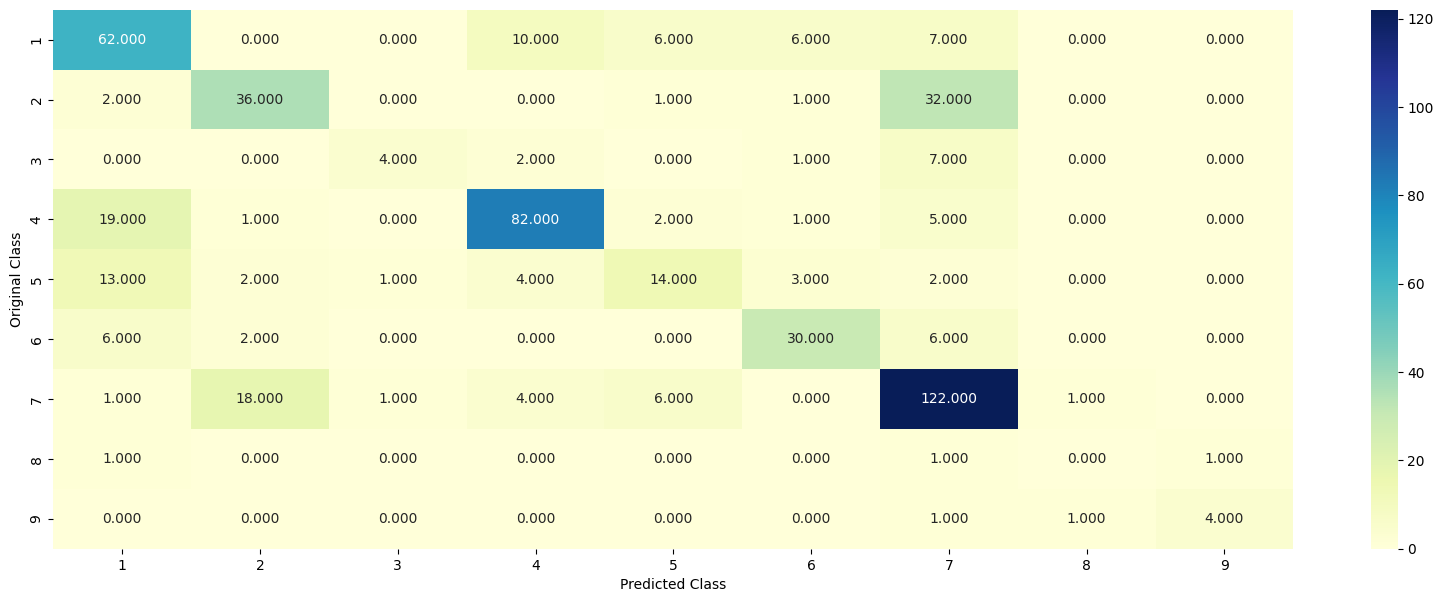

-------------------- Precision matrix (Columm Sum=1) --------------------


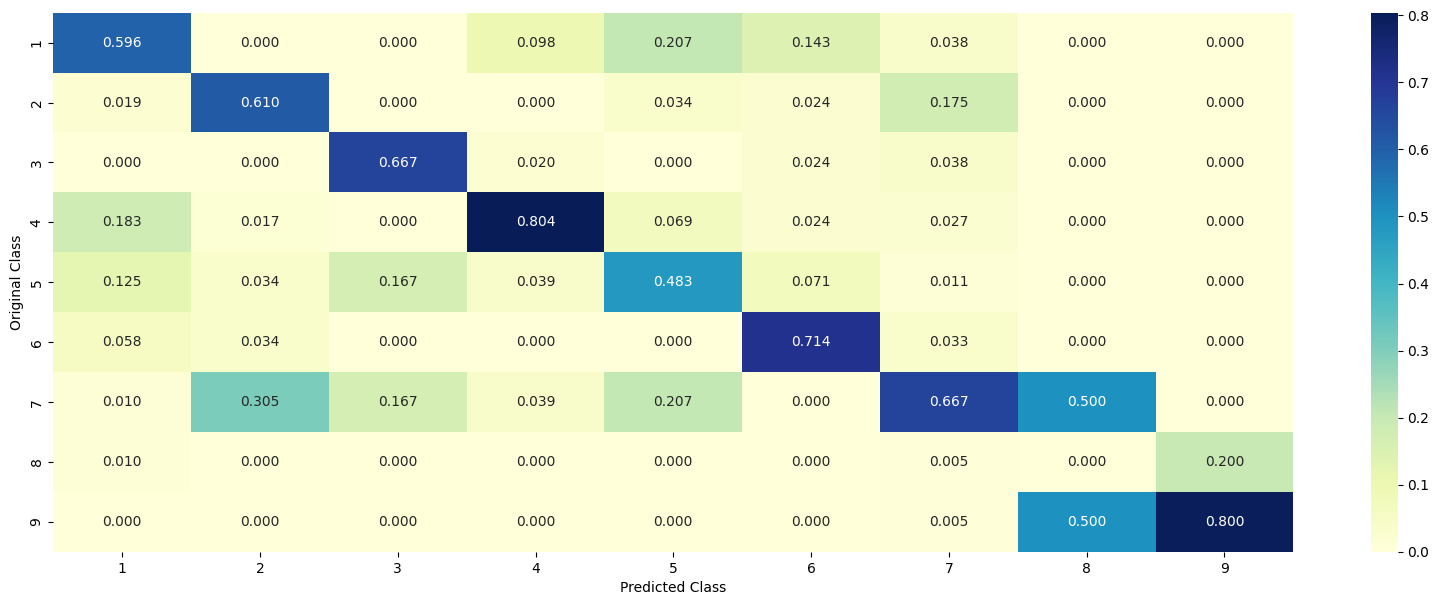

-------------------- Recall matrix (Row sum=1) --------------------


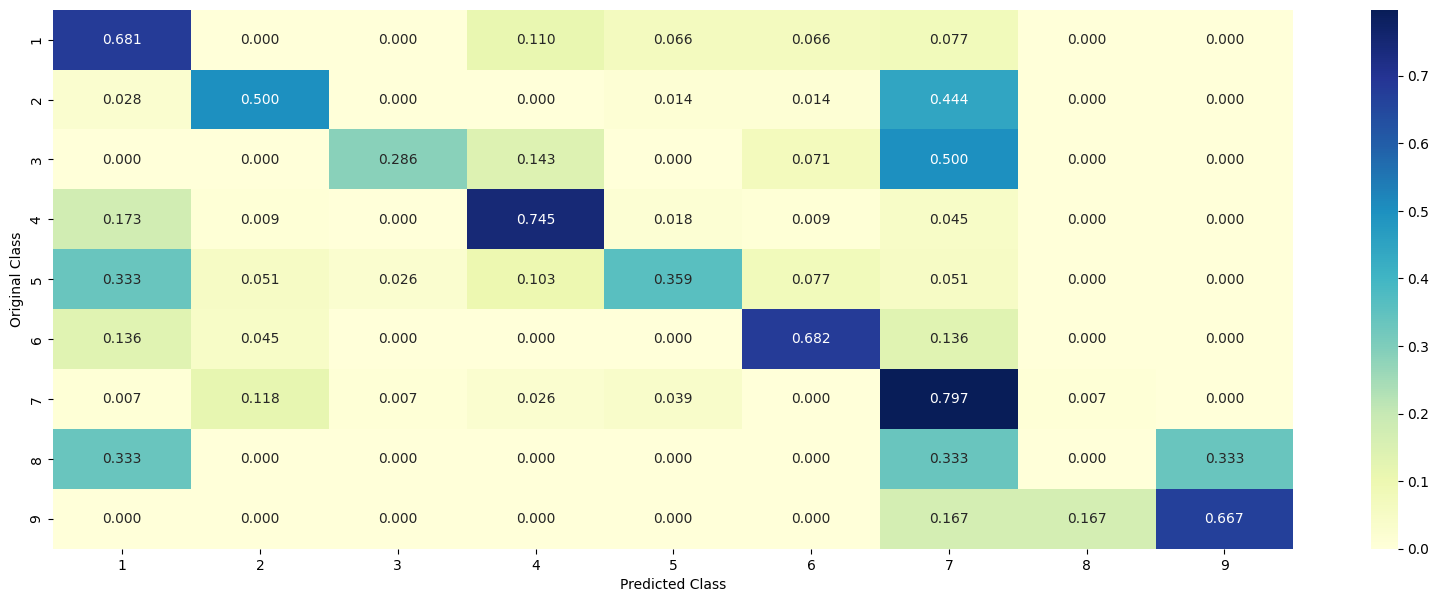

In [61]:
#Testing the model with best hyper paramters
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [62]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

##### 3.2. Classes without balancing

In [65]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for alpha = 1e-06
Log Loss : 1.1980747146570796
for alpha = 1e-05
Log Loss : 1.1615236907111601
for alpha = 0.0001
Log Loss : 1.0178325436176616
for alpha = 0.001
Log Loss : 0.9990218842158198
for alpha = 0.01
Log Loss : 1.071172219400429
for alpha = 0.1
Log Loss : 1.2917651270077153
for alpha = 1
Log Loss : 1.5917082153182254
For values of best alpha =  0.001 The train log loss is: 0.5456498635010882
For values of best alpha =  0.001 The cross validation log loss is: 0.9990218842158198
For values of best alpha =  0.001 The test log loss is: 1.0741667371763965


Log loss : 0.9990218842158198
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


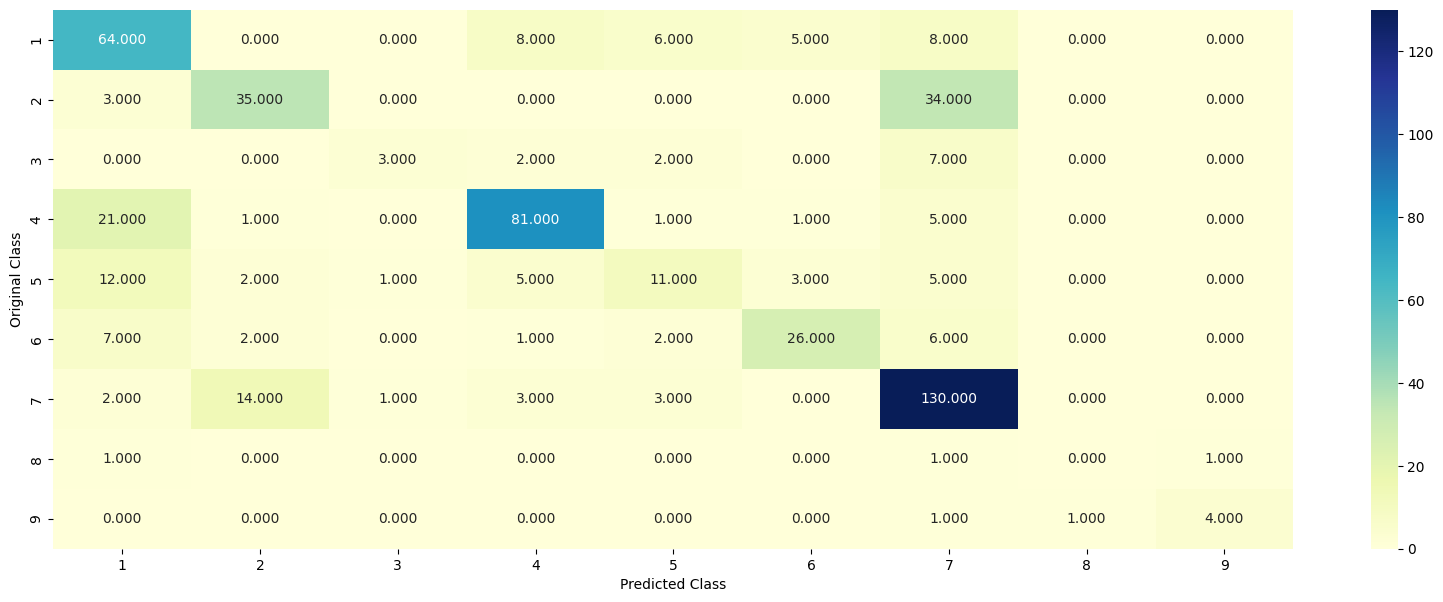

-------------------- Precision matrix (Columm Sum=1) --------------------


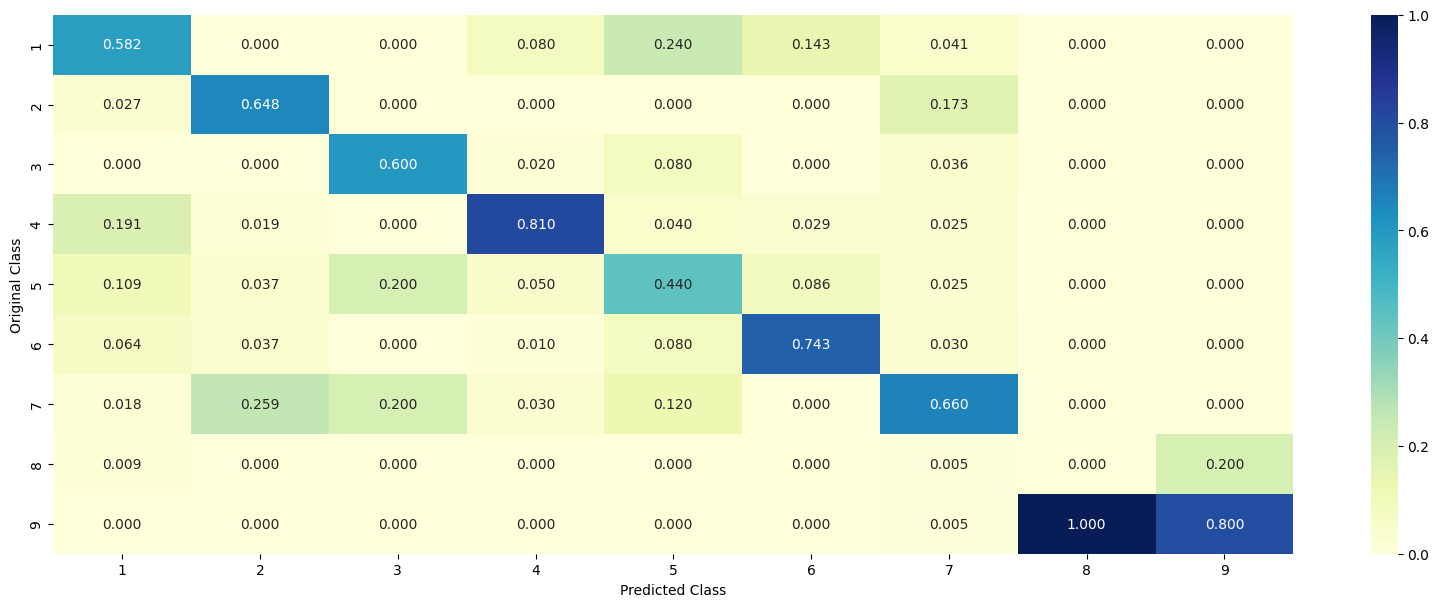

-------------------- Recall matrix (Row sum=1) --------------------


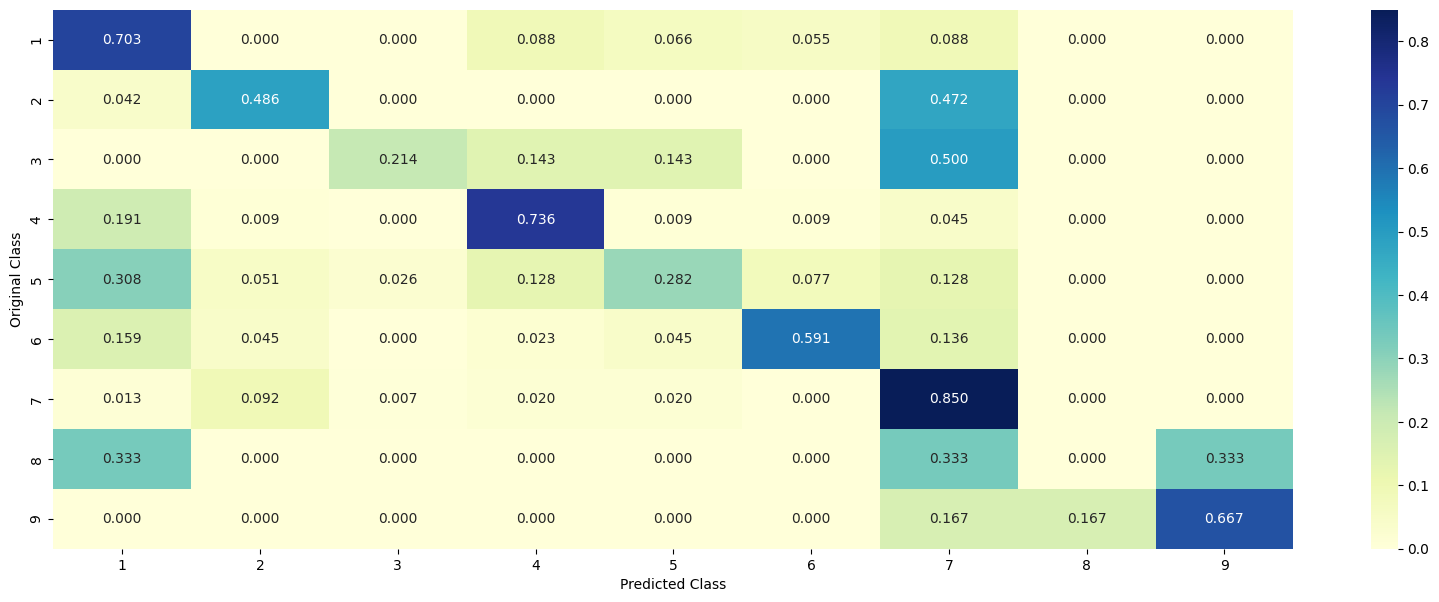

In [66]:
#Testing the model with best hyper paramters
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4. Linear SVM

In [69]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

for C = 1e-05
Log Loss : 1.2377914038294633
for C = 0.0001
Log Loss : 1.170408170207536
for C = 0.001
Log Loss : 1.0296860022322838
for C = 0.01
Log Loss : 1.0975964170737798
for C = 0.1
Log Loss : 1.2363277858406108
for C = 1
Log Loss : 1.6230297654958679
for C = 10
Log Loss : 1.6227045286056374
for C = 100
Log Loss : 1.6227045166879837
For values of best alpha =  0.001 The train log loss is: 0.5985510966536574
For values of best alpha =  0.001 The cross validation log loss is: 1.0296860022322838
For values of best alpha =  0.001 The test log loss is: 1.135654316872675


Log loss : 1.0296860022322838
Number of mis-classified points : 0.33646616541353386
-------------------- Confusion matrix --------------------


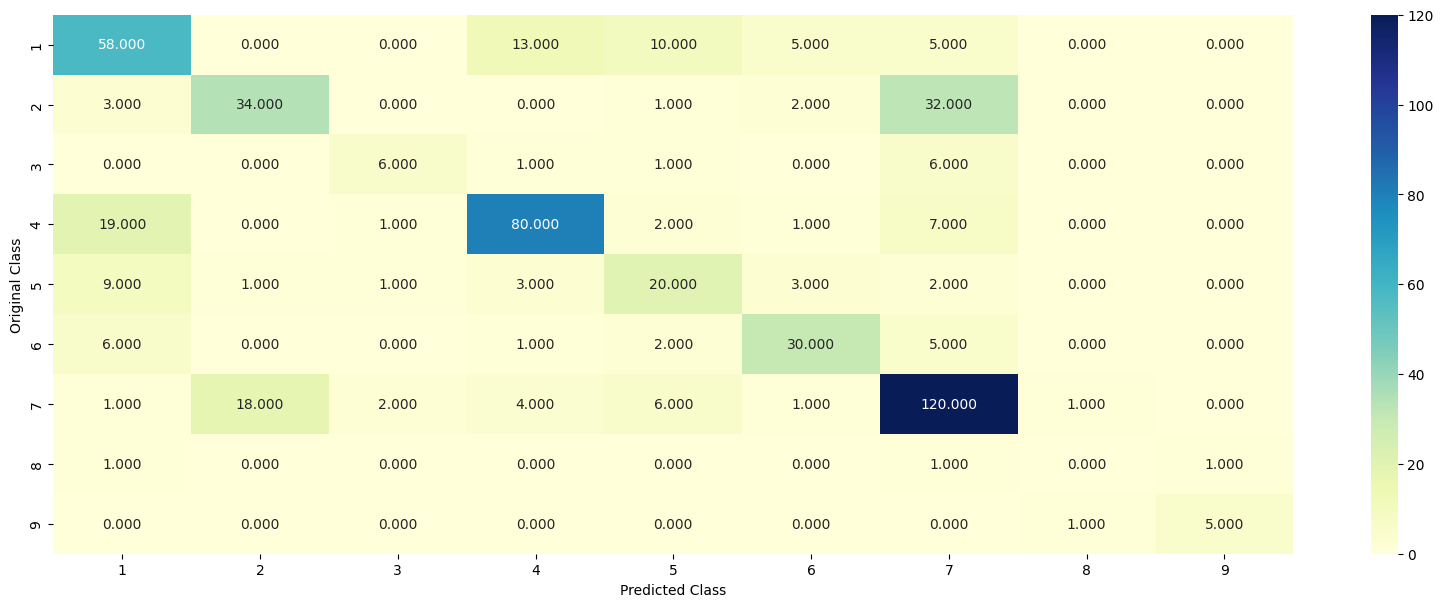

-------------------- Precision matrix (Columm Sum=1) --------------------


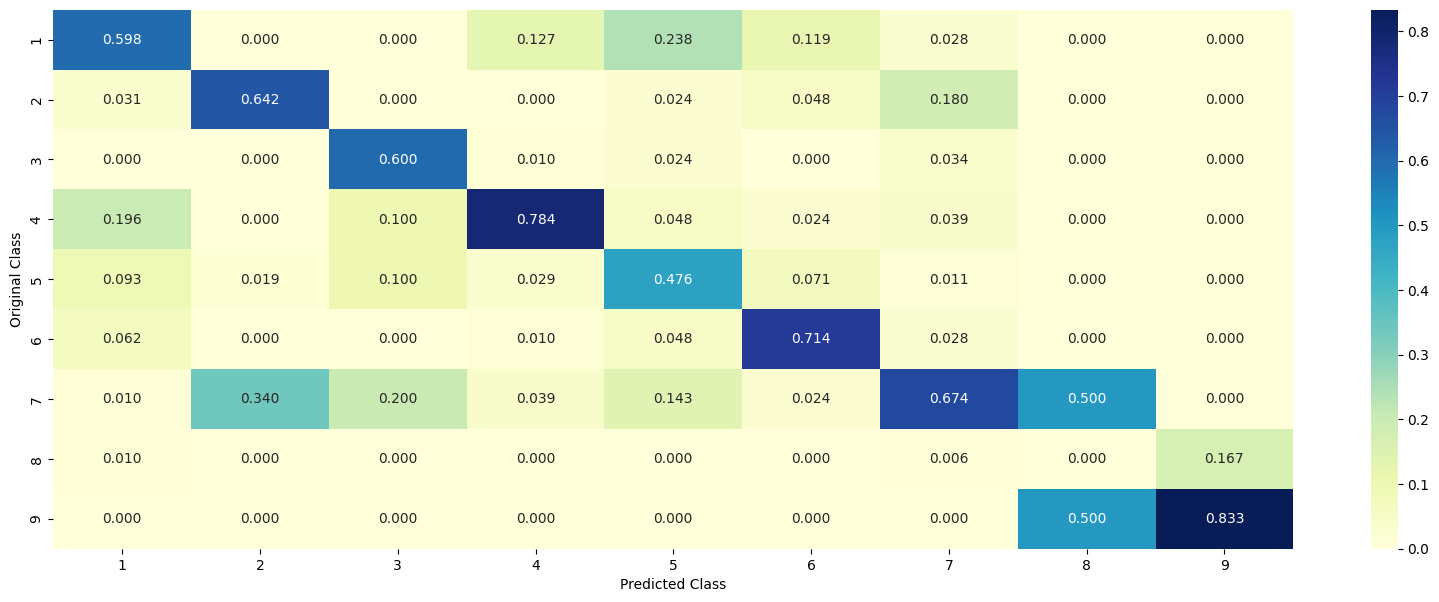

-------------------- Recall matrix (Row sum=1) --------------------


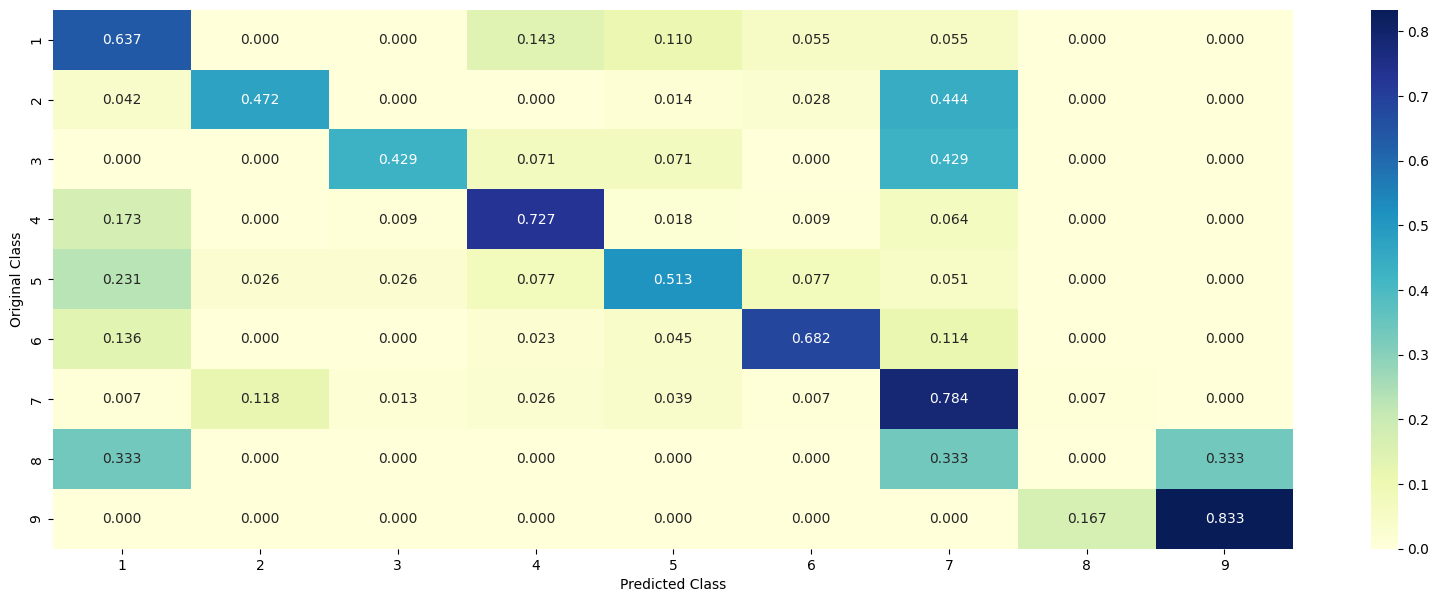

In [70]:
#Testing model with best hyper parameters
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### 5.1. Random Forest Classifier (With TfidVectorizer)

In [73]:
alpha = [50,100,200,500]
max_depth = [3,5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y))

for n_estimators = 50 and max depth =  3
Log Loss : 1.318398024092602
for n_estimators = 50 and max depth =  5
Log Loss : 1.2309617498246626
for n_estimators = 50 and max depth =  10
Log Loss : 1.1593855173873366
for n_estimators = 100 and max depth =  3
Log Loss : 1.309792459467391
for n_estimators = 100 and max depth =  5
Log Loss : 1.2197929324546226
for n_estimators = 100 and max depth =  10
Log Loss : 1.1540584160500305
for n_estimators = 200 and max depth =  3
Log Loss : 1.287844662278046
for n_estimators = 200 and max depth =  5
Log Loss : 1.2073860610367386
for n_estimators = 200 and max depth =  10
Log Loss : 1.1395852667295197
for n_estimators = 500 and max depth =  3
Log Loss : 1.2900610663742949
for n_estimators = 500 and max depth =  5
Log Loss : 1.2097326532287613
for n_estimators = 500 and max depth =  10
Log Loss : 1.1355135669362104
For values of best estimator =  200 The train log loss is: 0.6466934666885856
For values of best estimator =  200 The cross validation log

Log loss : 1.1395852667295197
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


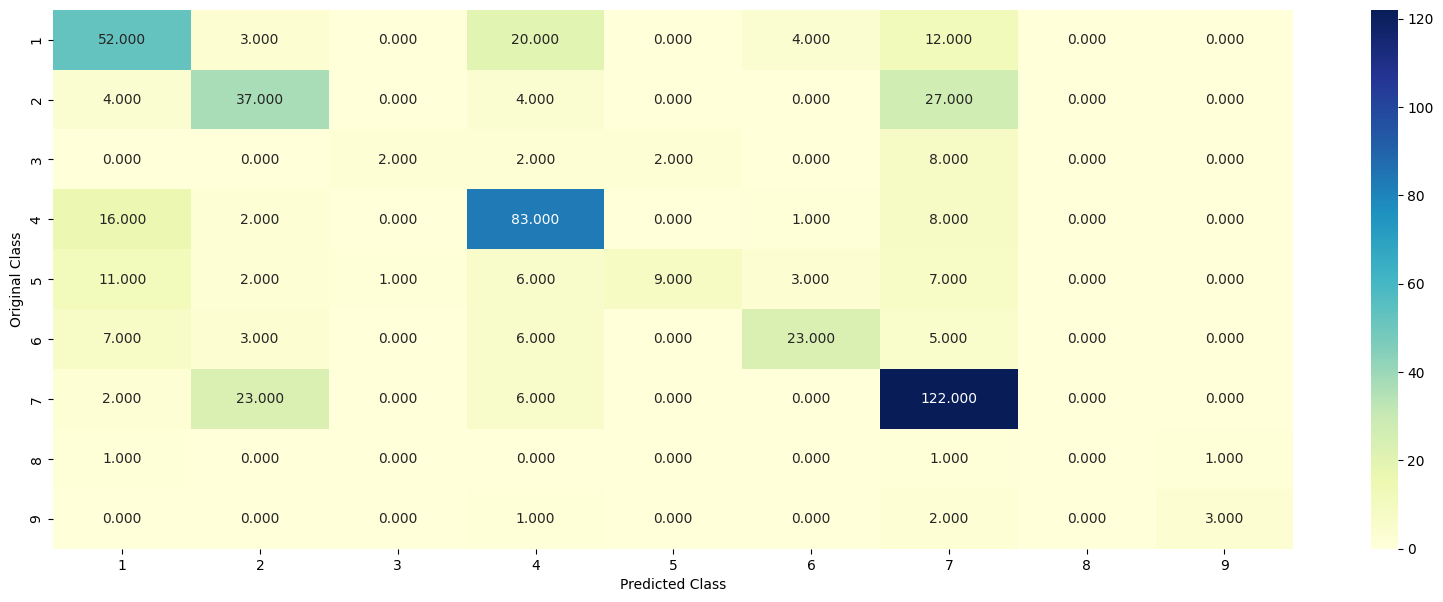

-------------------- Precision matrix (Columm Sum=1) --------------------


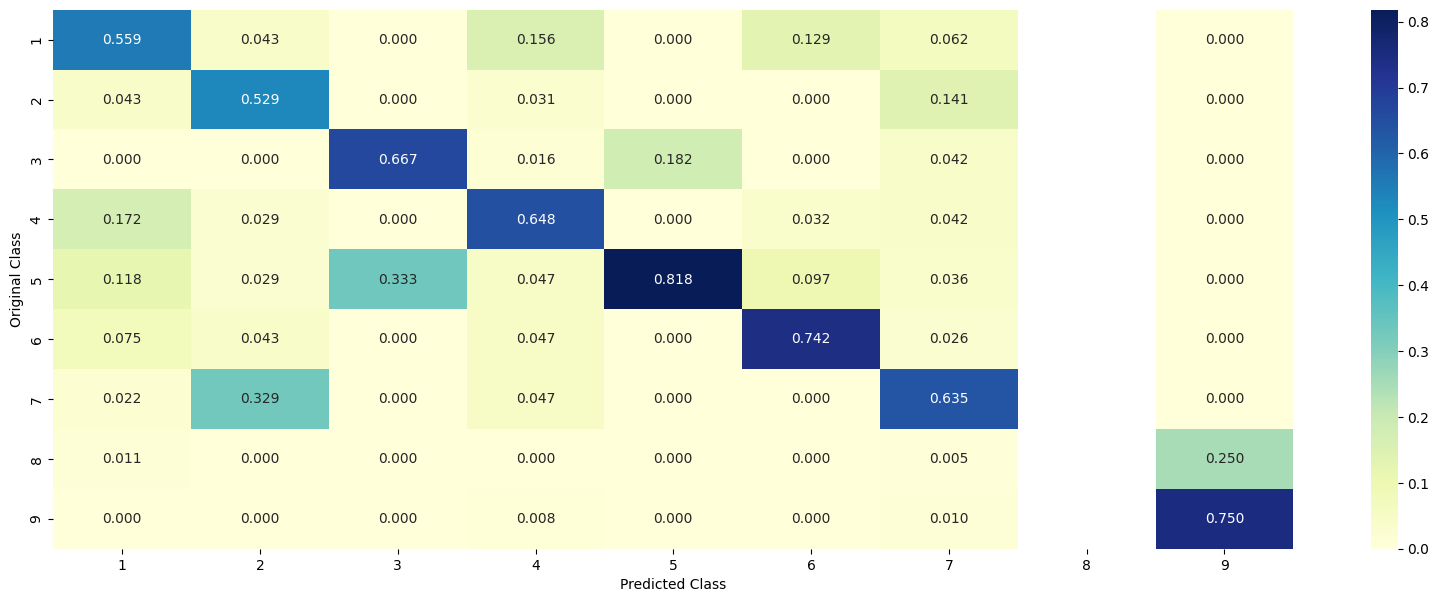

-------------------- Recall matrix (Row sum=1) --------------------


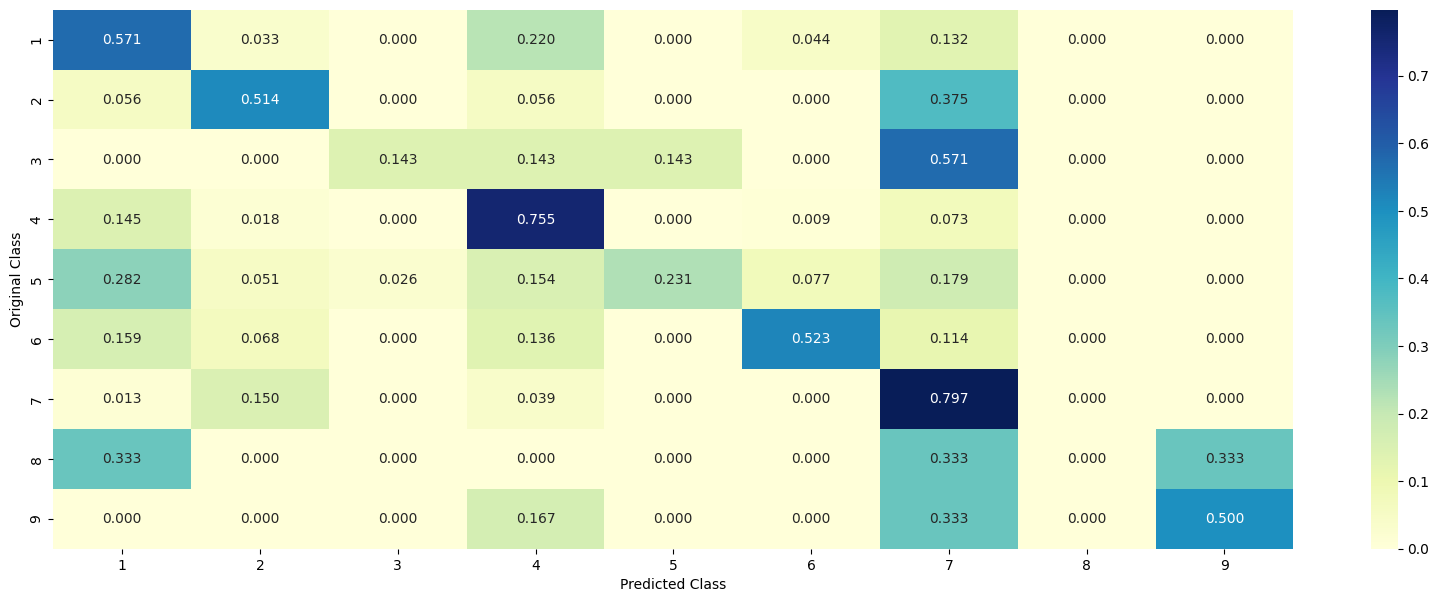

In [74]:
#Testing model with best hyper parameters 
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,y_cv, clf)

#### 5.2. Random Forest Classifier (With Response coding)

In [75]:
alpha = [50,100,200,500]
max_depth = [3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y))

for n_estimators = 50 and max depth =  3
Log Loss : 1.3542191339631648
for n_estimators = 50 and max depth =  5
Log Loss : 1.331605789395462
for n_estimators = 50 and max depth =  10
Log Loss : 1.5141941632440084
for n_estimators = 100 and max depth =  3
Log Loss : 1.3816293119114236
for n_estimators = 100 and max depth =  5
Log Loss : 1.3109713340966636
for n_estimators = 100 and max depth =  10
Log Loss : 1.553549071827135
for n_estimators = 200 and max depth =  3
Log Loss : 1.3843188276511031
for n_estimators = 200 and max depth =  5
Log Loss : 1.36031782068101
for n_estimators = 200 and max depth =  10
Log Loss : 1.6275858506916008
for n_estimators = 500 and max depth =  3
Log Loss : 1.4302659445676065
for n_estimators = 500 and max depth =  5
Log Loss : 1.3061937181004901
for n_estimators = 500 and max depth =  10
Log Loss : 1.6147935008864753
For values of best alpha =  200 The train log loss is: 0.03790118693895087
For values of best alpha =  200 The cross validation log loss is

Log loss : 1.6275858506916008
Number of mis-classified points : 0.6146616541353384
-------------------- Confusion matrix --------------------


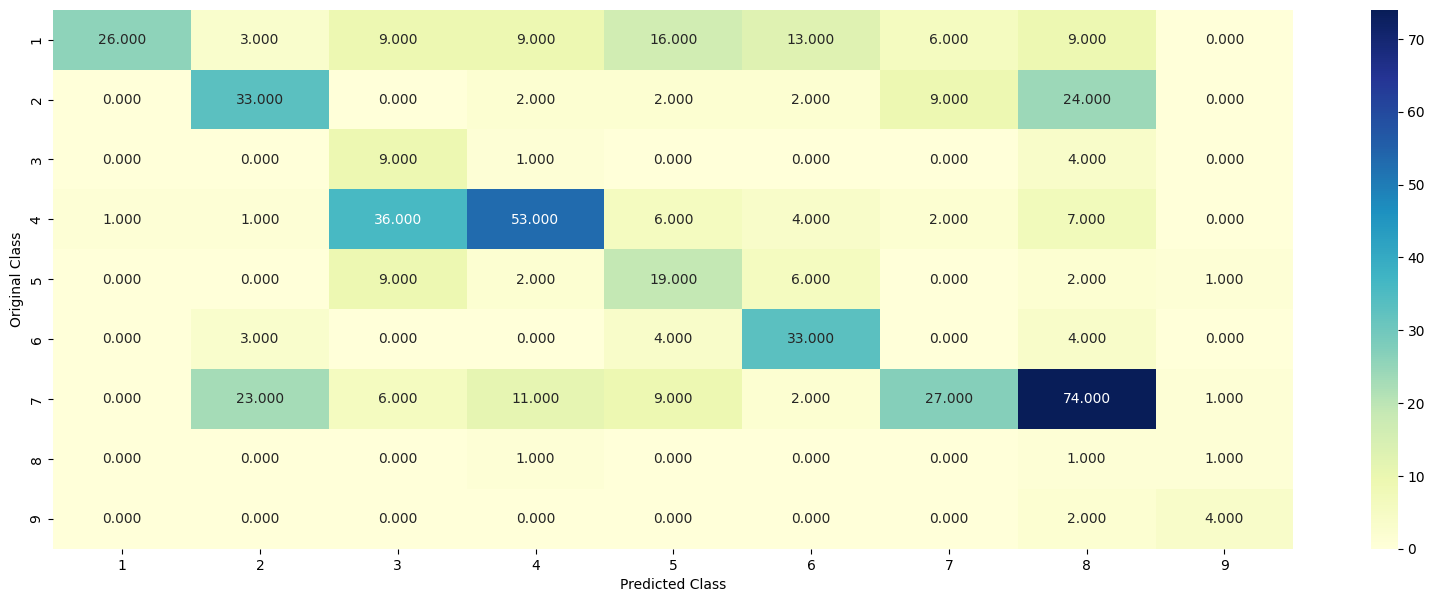

-------------------- Precision matrix (Columm Sum=1) --------------------


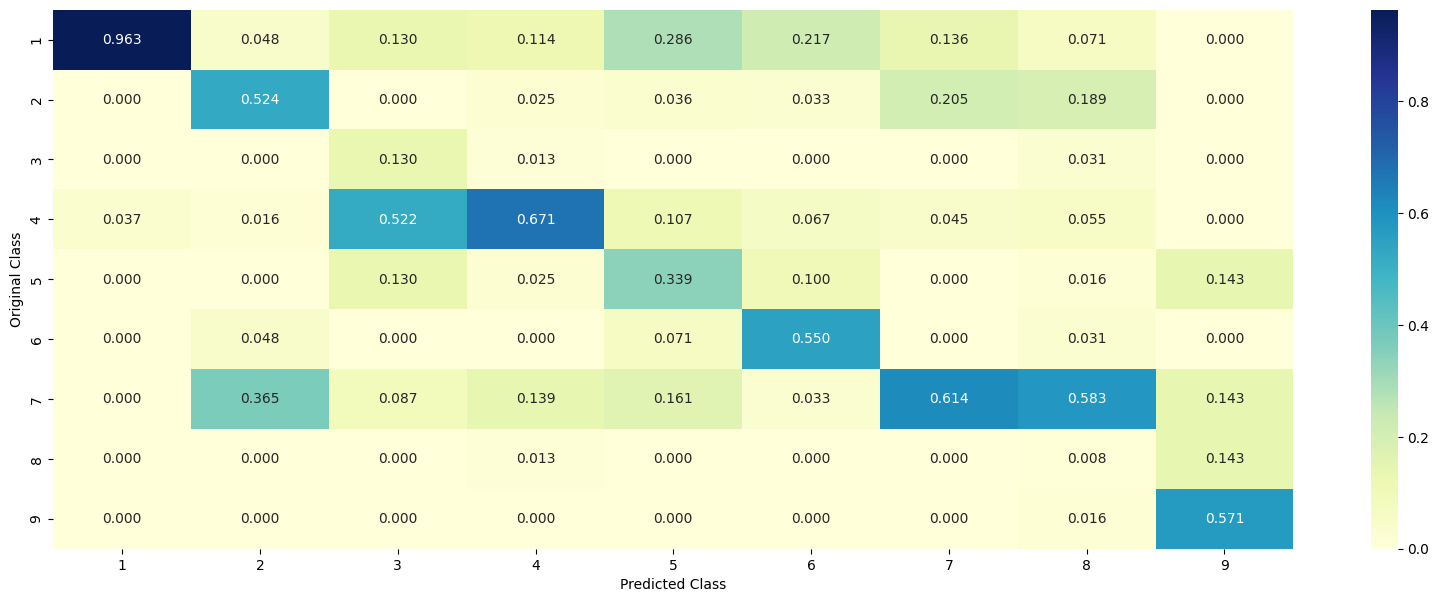

-------------------- Recall matrix (Row sum=1) --------------------


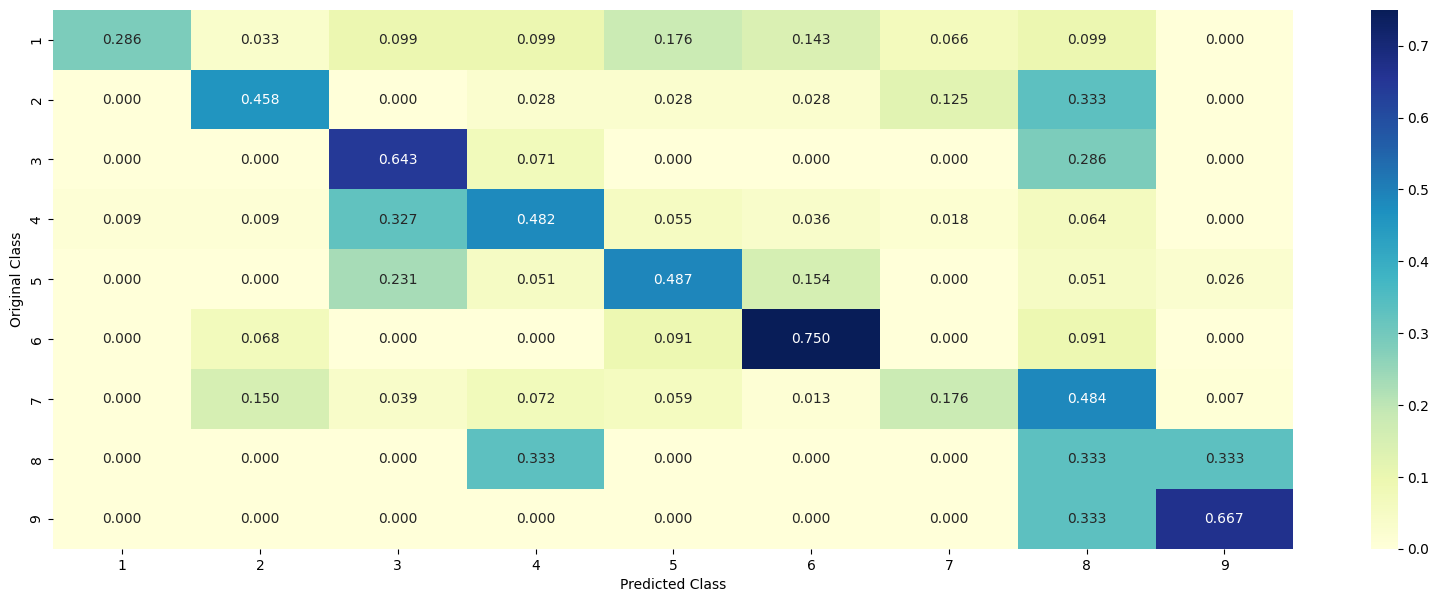

In [76]:
#Testing model with best hyper parameters
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

### Stacking Classifier

In [79]:
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=1e-5)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

clf4 = KNeighborsClassifier(n_neighbors=5)
clf4.fit(train_x_onehotCoding,train_y)
sig_clf4 = CalibratedClassifierCV(clf4, method="sigmoid")

clf5 = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf5.fit(train_x_onehotCoding,train_y)
sig_clf5 = CalibratedClassifierCV(clf5, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
sig_clf4.fit(train_x_onehotCoding, train_y)
print("K Nearest Neighbour : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf4.predict_proba(cv_x_onehotCoding))))
sig_clf5.fit(train_x_onehotCoding, train_y)
print("Random Forest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf5.predict_proba(cv_x_onehotCoding))))

Logistic Regression :  Log Loss: 1.00
Support vector machines : Log Loss: 1.03
Naive Bayes : Log Loss: 1.21
K Nearest Neighbour : Log Loss: 1.27
Random Forest : Log Loss: 1.14


In [80]:
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf5',clf5)], final_estimator=lr)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.748
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.365
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.042
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.016
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.037
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.113


In [81]:
print("-"*50)
alpha = [0.00001,0.0001,0.001,0.01,0.1,1.0] 
best_alpha = 999
for i in alpha:
    lr1 = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
    sclf1 = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf3',clf3)], final_estimator=lr1)
    sclf1.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf1.predict_proba(cv_x_onehotCoding))))
    log_error1 =log_loss(cv_y, sclf1.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error1:
        best_alpha = log_error1

--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000010 Log Loss: 6.188
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.368
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.106
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.075
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.196
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.820


Log loss (train) on the stacking classifier : 0.45158718583276464
Log loss (CV) on the stacking classifier : 1.0162014890048192
Log loss (test) on the stacking classifier : 1.0667478346265393
Number of missclassified point : 0.3774436090225564
-------------------- Confusion matrix --------------------


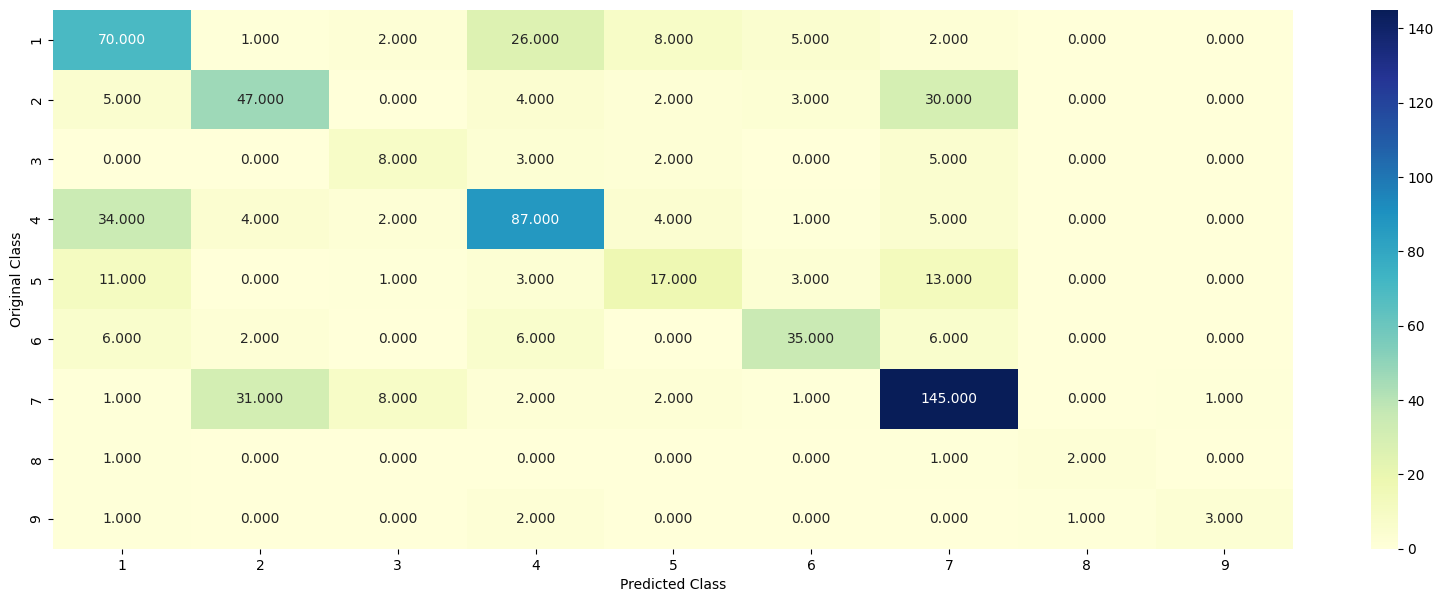

-------------------- Precision matrix (Columm Sum=1) --------------------


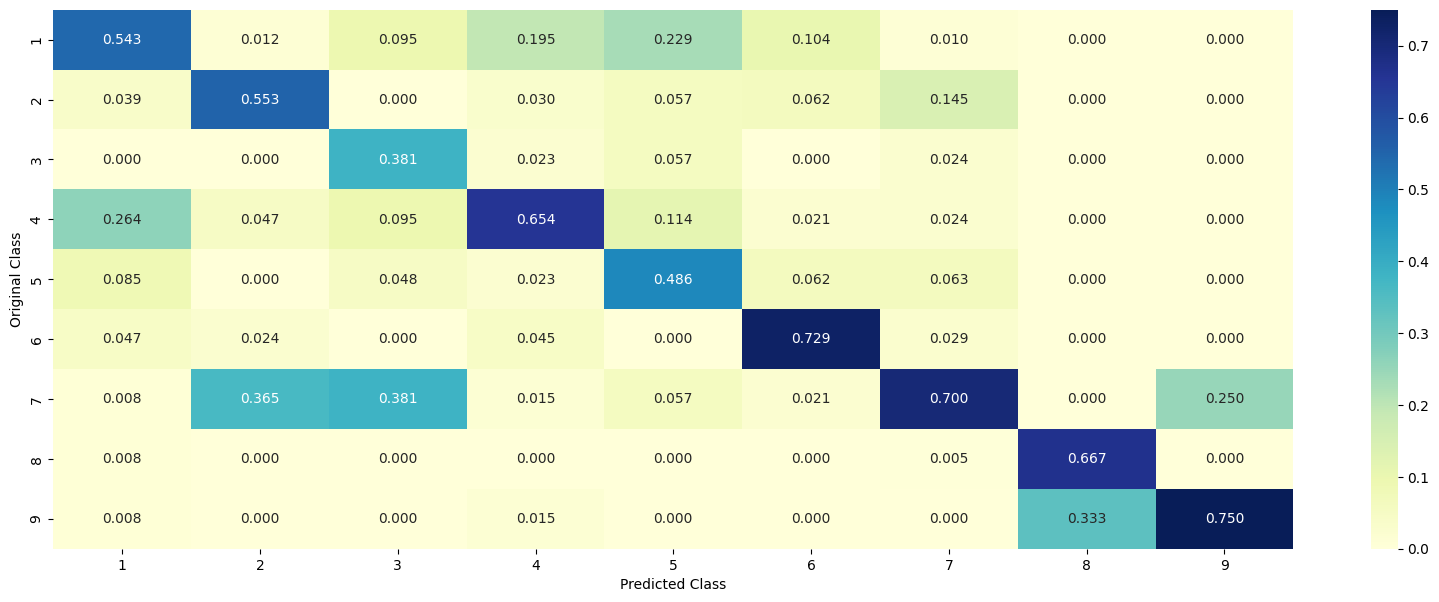

-------------------- Recall matrix (Row sum=1) --------------------


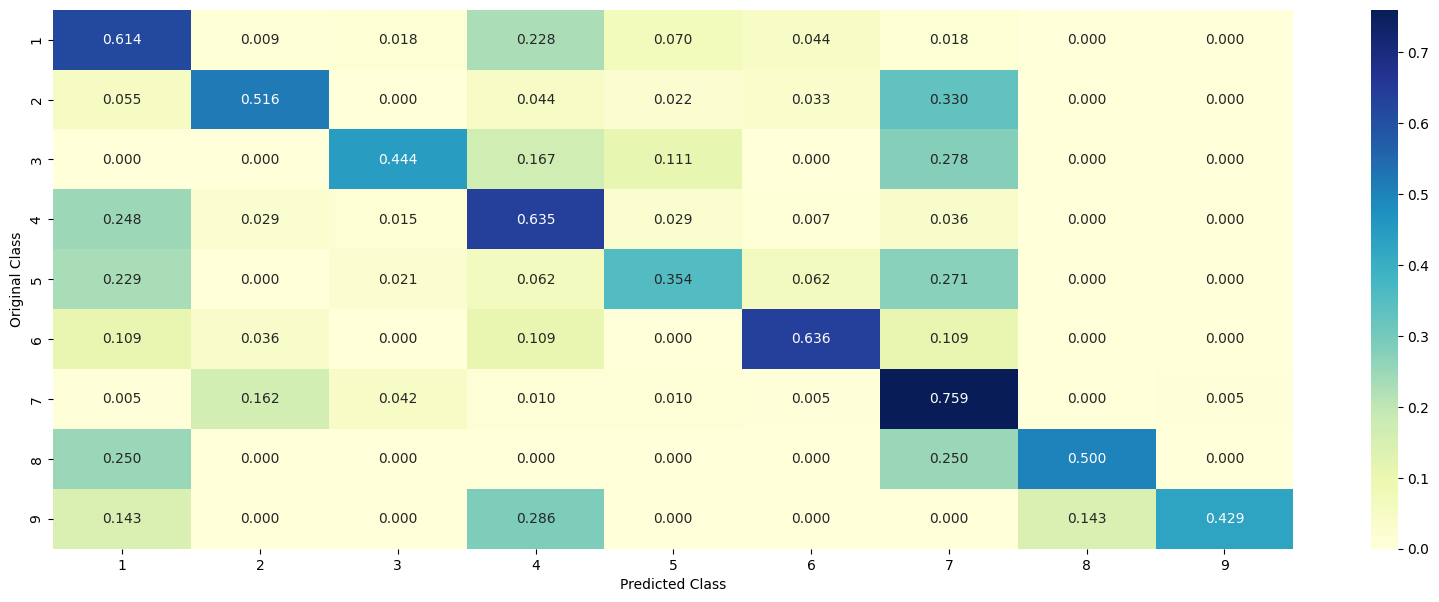

In [83]:
# testing the model with the best hyper parameters
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf5',clf5)], final_estimator=lr)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [84]:
num_classes = 10

model = Sequential([
    Dense(512, activation='relu', input_shape=(train_x_onehotCoding.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
model.fit(train_x_onehotCoding, y_train, epochs=12, batch_size=48,
          validation_data=(cv_x_onehotCoding, y_cv))

Epoch 1/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 588ms/step - accuracy: 0.4147 - loss: 1.7383 - val_accuracy: 0.6504 - val_loss: 1.1398
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step - accuracy: 0.7771 - loss: 0.7187 - val_accuracy: 0.6523 - val_loss: 1.5518
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 534ms/step - accuracy: 0.8053 - loss: 0.5113 - val_accuracy: 0.6447 - val_loss: 1.6024
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - accuracy: 0.8524 - loss: 0.3992 - val_accuracy: 0.6523 - val_loss: 1.6088
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 420ms/step - accuracy: 0.8568 - loss: 0.3562 - val_accuracy: 0.6579 - val_loss: 1.7778
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 475ms/step - accuracy: 0.8677 - loss: 0.3224 - val_accuracy: 0.6560 - val_loss: 1.7518
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 531ms/step - accuracy: 0.8903 - loss: 0.2768 - val_accuracy: 0.6504 - val_loss: 2.0085
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - accuracy: 0.8776 - loss: 0.3049 - val_accu

In [86]:
y_pred_probs = model.predict(test_x_onehotCoding)

# Convert to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# If y_test is one-hot encoded, convert it too:
y_true_classes = test_y

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [87]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

[[ 66   1   2  22  18   3   2   0   0]
 [  6  56   0   3   2   2  22   0   0]
 [  0   0   7   3   1   0   7   0   0]
 [ 34   4   2  84   9   1   3   0   0]
 [  5   2   1   3  28   1   8   0   0]
 [  6   2   0   3   2  34   8   0   0]
 [  3  36   4   2   6   1 139   0   0]
 [  1   0   0   0   0   0   1   2   0]
 [  1   0   0   1   0   0   0   1   4]]


-------------------- Confusion matrix --------------------


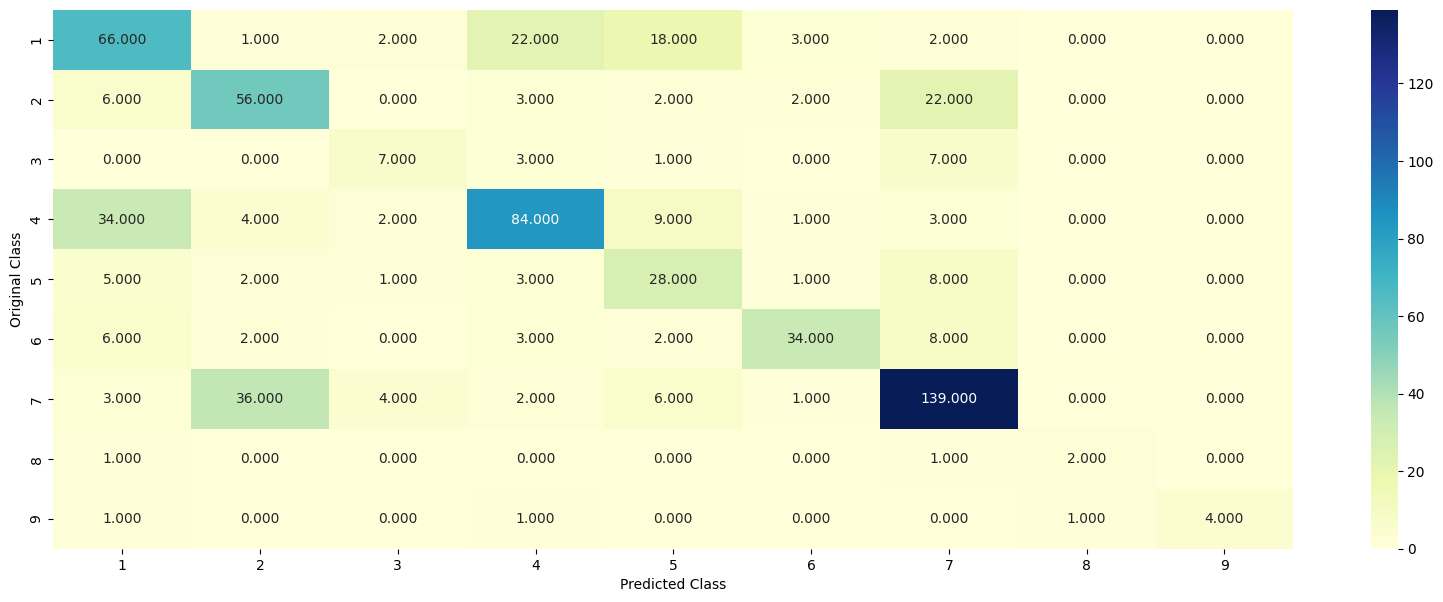

-------------------- Precision matrix (Columm Sum=1) --------------------


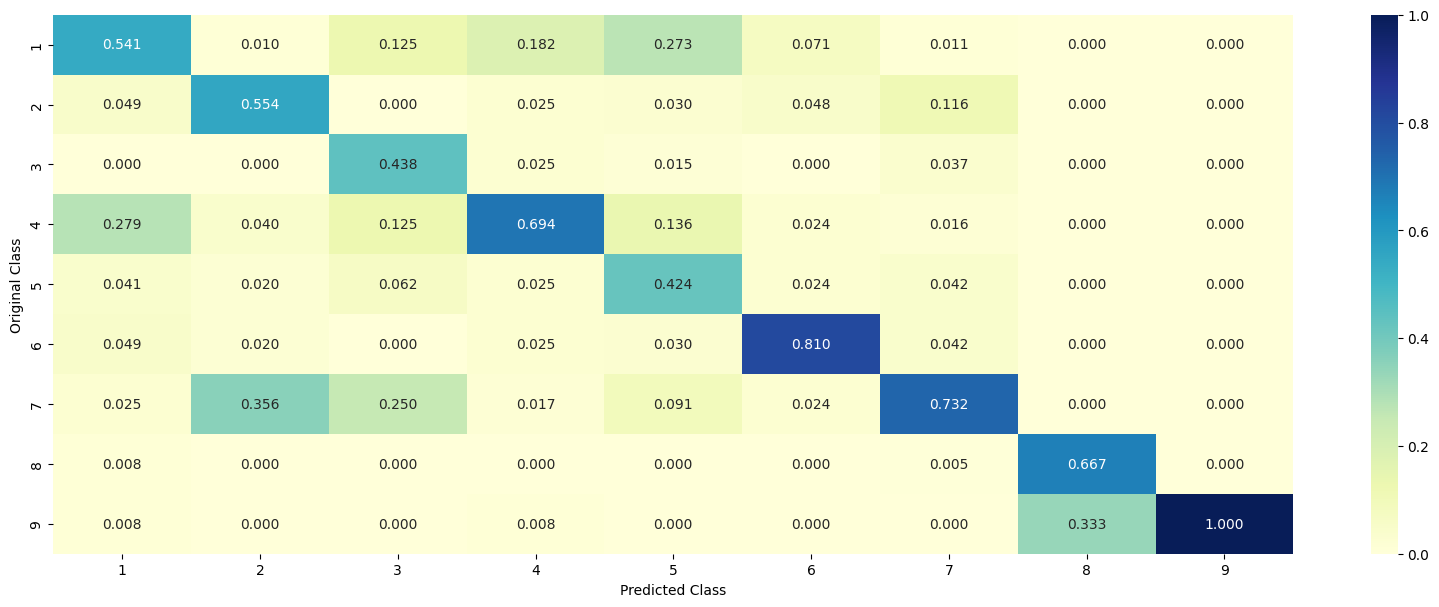

-------------------- Recall matrix (Row sum=1) --------------------


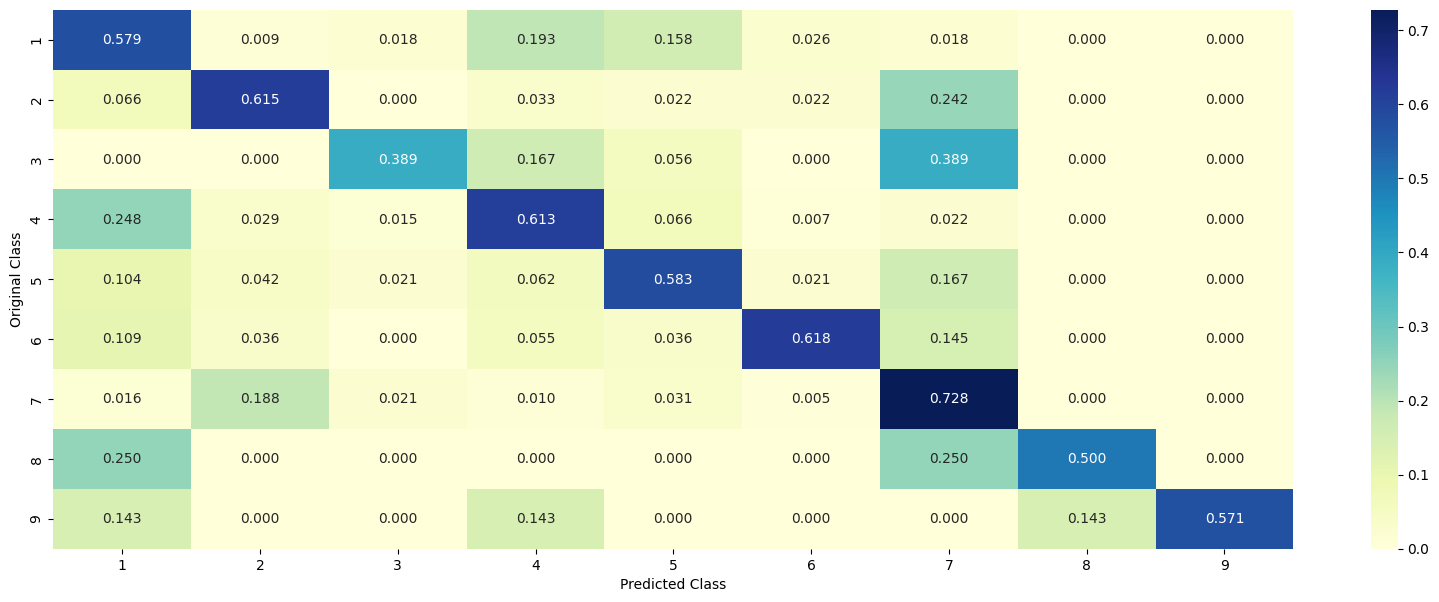

In [88]:
plot_confusion_matrix(test_y=test_y, predict_y=y_pred_classes)